### CYPLAN255-FINAL PROJECT
# **Factors Affecting Housing Prices in Santa Clara County: *A Hedonic Method***



*Charles Qianchuan LI*




Abstract: 

Housing prices are usually related to multiple factors, and it is important to learn how they can affect the market for future home buyers. Based on the Hedonic Pricing Model and the Geographically Weighted Regression Model, the study analyzes several common factors that could have potential impacts on the local real estate market of Santa Clara County. It shows different weights of different factors and examines the geographical differences among them. 
   
   
   

#### 1. Research Question: *How* do different factors affect housing prices in Santa Clara County?

#### 2. Methodology:
* Hedonic Model [1] : P=αS+βE+γL+ε 
    * P is the vector of property sales or rental prices, and S, E and L are the sets of vectors of structural, environmental and locational attributes, respectively, of the analyzed properties, and α, β and γ are the vectors of estimated regression coefficients, while ɛ is the vector of random error.
    * S: Beds, Baths, Sizes, etc.
    * E: Accessibility to public parks, the number of crime cases, etc.
    * L: Accessibility to tech companies, hospitals, schools, rail stations, etc. 
    
    <br>
* Geographically Weighted Regression Model (GWR) [2]: Yi=β0(ui,vi)+∑βj(ui,vi)Xji+εi
    * yi is the dependent variable, Xji is the jth independent variable, βj (ui,vi)  is the jth coefficient at location (ui,vi), and εi  is the random error term. Unlike OLS, the parameters are allowed to vary by location (ui,vi).
    * GWR is a promoted regression model which provides an effective means to estimate how the same factors may evoke different responses across locations and by so doing, bring to the fore the role of geographical context on human preferences and behavior.
    
    <br>
* General Strategy:
    * Using basic non-spital regression model to conduct basic hedonic analysis.
    * Using GWR component to conduct spatial hedonic analysis.

#### 3. Process:
* I Data Preparation:
Using Census API, Geocoding, Web Scraping, and other tools to acquire and clean relevant data.

* II Data Processing + Analysis(i): 
Using Network Analysis and Spatial Join to get accessibility data and data for regression analysis.

* III Data Processing + Analysis(ii): 
Using Basic Regression Model [3] and Geographically Weighted Regression (GWR)[4] to conduct analysis.

* IV Conclusions + Contributions + Limitations

* V References

In [2]:
# imports
import numpy as np
import geopandas as gpd
import pandas as pd
import json    
import requests
import pprint
from pandana.loaders import osm
import warnings
import pandana
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import networkx as nx
import osmnx as os
from descartes import PolygonPatch
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon
from census import Census
from us import states
import os
import jenkspy
import seaborn as sns
import random
from collections.abc import Mapping
import mapbox
from mapbox import Geocoder
import utm
import math
import lxml
from lxml.html.soupparser import fromstring
from bs4 import BeautifulSoup
import regex as re
import prettify
import numbers
import html_text
import pyproj
from pyproj import CRS
from pyproj import Transformer
import pysal as ps
import spreg
import libpysal
import plotly.express as px
import plotly.graph_objects as go
import libpysal as ps
from libpysal  import weights
from libpysal.weights import Queen
import esda
from esda.moran import Moran, Moran_Local
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_local_autocorrelation
from splot.libpysal import plot_spatial_weights
from giddy.directional import Rose
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer, LineLocation
from spreg import OLS
from spreg import MoranRes
from spreg import ML_Lag
from spreg import ML_Error 
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap
import warnings
warnings.filterwarnings('ignore') 
import time

## I-Data Preparation

#### 1.Demographics (Census API + Dot Density + Interpolate)

In [12]:
# Read Base Map through API
tracts=gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2010/TRACT/2010/tl_2010_06_tract10.zip")
tracts.head()

STATEFP10 COUNTYFP10 TRACTCE10      GEOID10 NAME10          NAMELSAD10  \
0        06        083    002103  06083002103  21.03  Census Tract 21.03   
1        06        083    002402  06083002402  24.02  Census Tract 24.02   
2        06        083    002102  06083002102  21.02  Census Tract 21.02   
3        06        083    002010  06083002010  20.10  Census Tract 20.10   
4        06        083    002009  06083002009  20.09  Census Tract 20.09   

  MTFCC10 FUNCSTAT10   ALAND10  AWATER10   INTPTLAT10    INTPTLON10  \
0   G5020          S   2838200      7603  +34.9306689  -120.4270588   
1   G5020          S  16288573     44468  +34.9287963  -120.4780833   
2   G5020          S   1352551         0  +34.9421111  -120.4267767   
3   G5020          S   2417990         0  +34.8714281  -120.4100285   
4   G5020          S   2603281         0  +34.8722878  -120.4277159   

                                            geometry  
0  POLYGON ((-120.41794 34.93834, -120.41766 34.9...  
1  POLYGON ((-120.47389 34.92081, -120.47428 34.9...  
2  POLYGON ((-120.41766 34.93834, -120.41794 34.9...  
3  POLYGON ((-120.41147 34.87962, -120.41141 34.8...  
4  POLYGON ((-120.42352 34.87928, -120.42286 34.8...

In [13]:
# Santa Clara Base Map
santa_clara_tract=tracts.loc[tracts['COUNTYFP10'] =='085']

In [14]:
# Basic Info
print(santa_clara_tract.crs)
santa_clara_tract.head()

epsg:4269


STATEFP10 COUNTYFP10 TRACTCE10      GEOID10   NAME10  \
921        06        085    509201  06085509201  5092.01   
922        06        085    510500  06085510500     5105   
923        06        085    509401  06085509401  5094.01   
924        06        085    509303  06085509303  5093.03   
925        06        085    503306  06085503306  5033.06   

               NAMELSAD10 MTFCC10 FUNCSTAT10  ALAND10  AWATER10   INTPTLAT10  \
921  Census Tract 5092.01   G5020          S  1579162         0  +37.4012062   
922     Census Tract 5105   G5020          S  2590775         0  +37.3927828   
923  Census Tract 5094.01   G5020          S   666430         0  +37.4069811   
924  Census Tract 5093.03   G5020          S   573577         0  +37.4060297   
925  Census Tract 5033.06   G5020          S  1667716         0  +37.3314079   

       INTPTLON10                                           geometry  
921  -122.0743461  POLYGON ((-122.06955 37.40840, -122.06951 37.4...  
922  -122.1201120  POLYGON ((-122.11405 37.38211, -122.11405 37.3...  
923  -122.1144543  POLYGON ((-122.12005 37.40626, -122.12000 37.4...  
924  -122.0922777  POLYGON ((-122.09708 37.40364, -122.09692 37.4...  
925  -121.8221350  POLYGON ((-121.81682 37.32850, -121.81767 37.3...

In [15]:
#Projection to standard Bay Area CRS:EPSG:26910
santa_clara_tract_project = santa_clara_tract.to_crs("epsg:26910")

<AxesSubplot:>

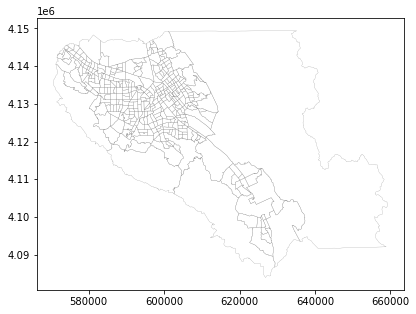

In [16]:
santa_clara_tract_project.plot(color='none', edgecolor='gray', linewidth=.2, figsize=(7,5))

In [17]:
#Access Demographics Data using CENSUS API

# define parameters of my API query
acs_total_pop = 'B01001_001E'  # total pop
acs_income = 'B07011_001E' #median income
acs_race_hispanic= 'B03003_003E' #hispanic pop
acs_race_not_hispanic= 'B03003_002E' #not hispanic
acs_race_white_alone= 'B03002_003E' #white alone
acs_race_black_alone= 'B03002_004E' #black alone
acs_race_asian_alone= 'B03002_006E' #asian alone
state = '06'  # CA
counties = '085'  # Santa Clara
year = 2019


# Access Tract Data Using my API key as an environmental variable
census_key = os.getenv("CENSUS_API")  

c = Census(census_key, year=year)
res = c.acs5.get((
    'NAME', acs_total_pop, acs_income, acs_race_hispanic, acs_race_not_hispanic, 
    acs_race_white_alone, acs_race_black_alone, acs_race_asian_alone), geo={
    'for': 'tract:*',
    'in': 'state:{} county:085'.format(states.CA.fips)
})

demo_tracts=pd.DataFrame(res)
demo_tracts

NAME  B01001_001E  \
0    Census Tract 5079.04, Santa Clara County, Cali...       3195.0   
1    Census Tract 5085.04, Santa Clara County, Cali...       8604.0   
2    Census Tract 5085.05, Santa Clara County, Cali...       4871.0   
3    Census Tract 5087.04, Santa Clara County, Cali...       7587.0   
4    Census Tract 5094.03, Santa Clara County, Cali...       5779.0   
..                                                 ...          ...   
367  Census Tract 5120.27, Santa Clara County, Cali...       4830.0   
368  Census Tract 5120.32, Santa Clara County, Cali...       2997.0   
369  Census Tract 5120.33, Santa Clara County, Cali...       9884.0   
370  Census Tract 5120.35, Santa Clara County, Cali...       4924.0   
371  Census Tract 5043.14, Santa Clara County, Cali...       4897.0   

     B07011_001E  B03003_003E  B03003_002E  B03002_003E  B03002_004E  \
0        93707.0        105.0       3090.0        853.0          0.0   
1        80673.0       1363.0       7241.0       1584.0         89.0   
2        87058.0        416.0       4455.0       1941.0          0.0   
3        72363.0       1491.0       6096.0       1962.0        303.0   
4        54388.0       1980.0       3799.0       1707.0        138.0   
..           ...          ...          ...          ...          ...   
367      49578.0       1252.0       3578.0       1595.0        188.0   
368      43405.0        941.0       2056.0       1292.0         48.0   
369      54500.0       2680.0       7204.0       3381.0        391.0   
370      40169.0       1489.0       3435.0       2088.0         84.0   
371      43512.0        875.0       4022.0        558.0         67.0   

     B03002_006E state county   tract  
0         2097.0    06    085  507904  
1         4940.0    06    085  508504  
2         2366.0    06    085  508505  
3         3587.0    06    085  508704  
4         1815.0    06    085  509403  
..           ...   ...    ...     ...  
367       1507.0    06    085  512027  
368        576.0    06    085  512032  
369       2780.0    06    085  512033  
370       1049.0    06    085  512035  
371       3275.0    06    085  504314  

[372 rows x 11 columns]

<AxesSubplot:>

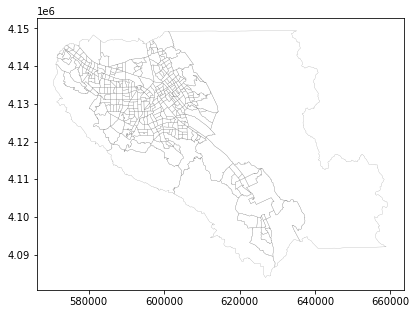

In [18]:
#join demographics data with tracts, projection, and build GeoDataframe
demo_blocks = pd.merge(demo_tracts, santa_clara_tract_project, how='outer', left_on='tract', right_on='TRACTCE10')
demo_blocks_geo = gpd.GeoDataFrame(demo_blocks, geometry='geometry')
demo_blocks_geo_project = demo_blocks_geo.to_crs("epsg:26910")
demo_blocks_geo_project.plot(color='none', edgecolor='gray', linewidth=.2, figsize=(7,5))

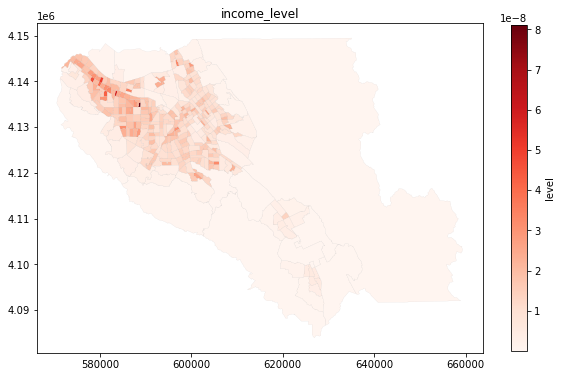

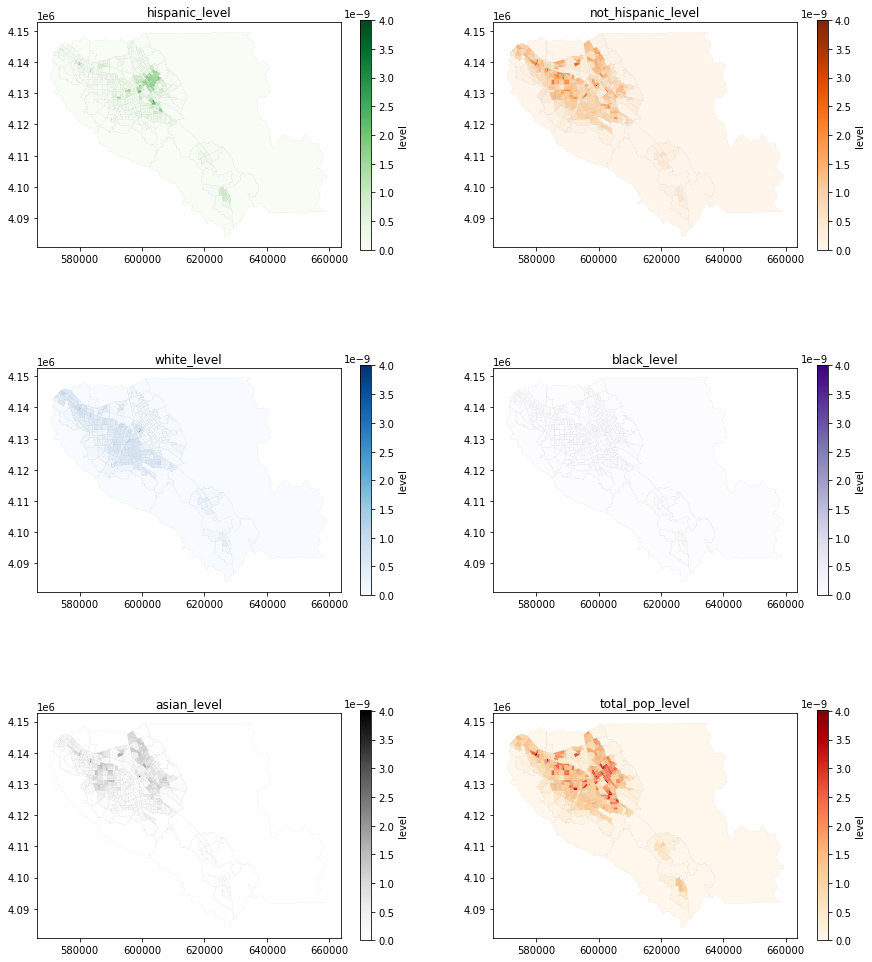

In [19]:
#Visualization 01:Demographics using normalized areas

#Normalization
demo_blocks_geo_project['area_sqmi'] = demo_blocks_geo_project.area / 3.861e-7
normalized_demographics= ['income_sqmi','hispanic_sqmi','not_hispanic_sqmi','white_sqmi','black_sqmi','asian_sqmi', 'total_pop_sqmi']
variables= ['B07011_001E','B03003_003E','B03003_002E','B03002_003E','B03002_004E','B03002_006E','B01001_001E']
colors= ['Reds','Greens','Oranges','Blues','Purples','Greys','OrRd']

for m in np.arange(7):
    demo_blocks_geo_project[normalized_demographics[m]]=demo_blocks_geo_project[variables[m]]/demo_blocks_geo_project['area_sqmi']

    
#Plotting

#income level
figure_income=demo_blocks_geo_project.plot(column=normalized_demographics[0],cmap=colors[0], edgecolor='gray', linewidth=.05,figsize=(10,10),
                             legend_kwds={'label': "level",
                                                  'orientation': "vertical",
                                                 'pad':0.05,
                                                 'shrink':0.6}, 
                             legend=True)
figure_income.set_title('income_level')


#Race
fig, ax = plt.subplots(3,2, figsize=(15,18))
x=0
for i in np.arange(3):
    for j in np.arange(2):
        x=x+1
        demo_blocks_geo_project.plot(ax=ax[i,j],column=normalized_demographics[x],cmap=colors[x], edgecolor='gray', linewidth=.05,legend=True,
                                     legend_kwds={'label': "level",
                                                  'orientation': "vertical",
                                                 'pad':0.05,
                                                 'shrink':0.8},
                                     vmin=0, 
                                     vmax=4.01e-9)
        ax[i,j].set_title(normalized_demographics[x].strip('_sqmi') + '_level')
        

In [10]:
#Turning Demographics into dot density

factor = 100
demo_blocks_geo_project[['total_pop_int','income_int','hispanic_int','not_hispanic_int','white_int','black_int','asian_int']] = round(demo_blocks_geo_project[['B01001_001E','B07011_001E','B03003_003E','B03003_002E','B03002_003E','B03002_004E','B03002_006E']] / factor).astype('int')
demo_blocks_geo_project[['minx','miny','maxx','maxy']]=demo_blocks_geo_project['geometry'].bounds[['minx','miny','maxx','maxy']]

#define a function generating random dots
def random_coordinates(row):
    results = []
    for var in ('total_pop_int','income_int','hispanic_int','not_hispanic_int','white_int','black_int','asian_int'):
        count = 0
        val = row[var]
        while count < val:
            x = random.uniform(row['minx'], row['maxx'])
            y = random.uniform(row['miny'], row['maxy'])
            pt = Point(x, y)
            if pt.within(row['geometry']):
                count += 1
                results.append([var, x, y])
    return pd.DataFrame(results, columns=('variable', 'x', 'y'))

results = demo_blocks_geo_project.apply(random_coordinates, axis=1)
results = pd.concat(results.tolist(), ignore_index=True)
results.head()

variable              x             y
0  total_pop_int  588527.281275  4.128996e+06
1  total_pop_int  588408.046028  4.128995e+06
2  total_pop_int  588452.353728  4.128969e+06
3  total_pop_int  588338.188191  4.128576e+06
4  total_pop_int  588193.813124  4.128871e+06

In [11]:
#Create Geodataframes
demo_points = gpd.GeoDataFrame(
    results, geometry=gpd.points_from_xy(results.x, results.y))
demo_points_projected=demo_points.set_crs("epsg:26910")

total_pop_points=demo_points_projected.loc[demo_points_projected['variable']=='total_pop_int']
income_points=demo_points_projected.loc[demo_points_projected['variable']=='income_int']
hispanic_points=demo_points_projected.loc[demo_points_projected['variable']=='hispanic_int']
not_hispanic_points=demo_points_projected.loc[demo_points_projected['variable']=='not_hispanic_int']
white_points=demo_points_projected.loc[demo_points_projected['variable']=='white_int']
black_points=demo_points_projected.loc[demo_points_projected['variable']=='black_int']
asian_points=demo_points_projected.loc[demo_points_projected['variable']=='asian_int']

In [12]:
hispanic_points.to_csv('hispanic_points.csv')
not_hispanic_points.to_csv('not_hispanic_points.csv')
total_pop_points.to_csv('total_pop_points.csv')

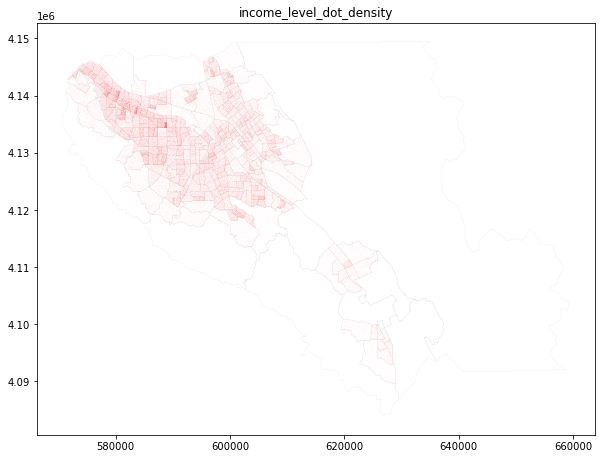

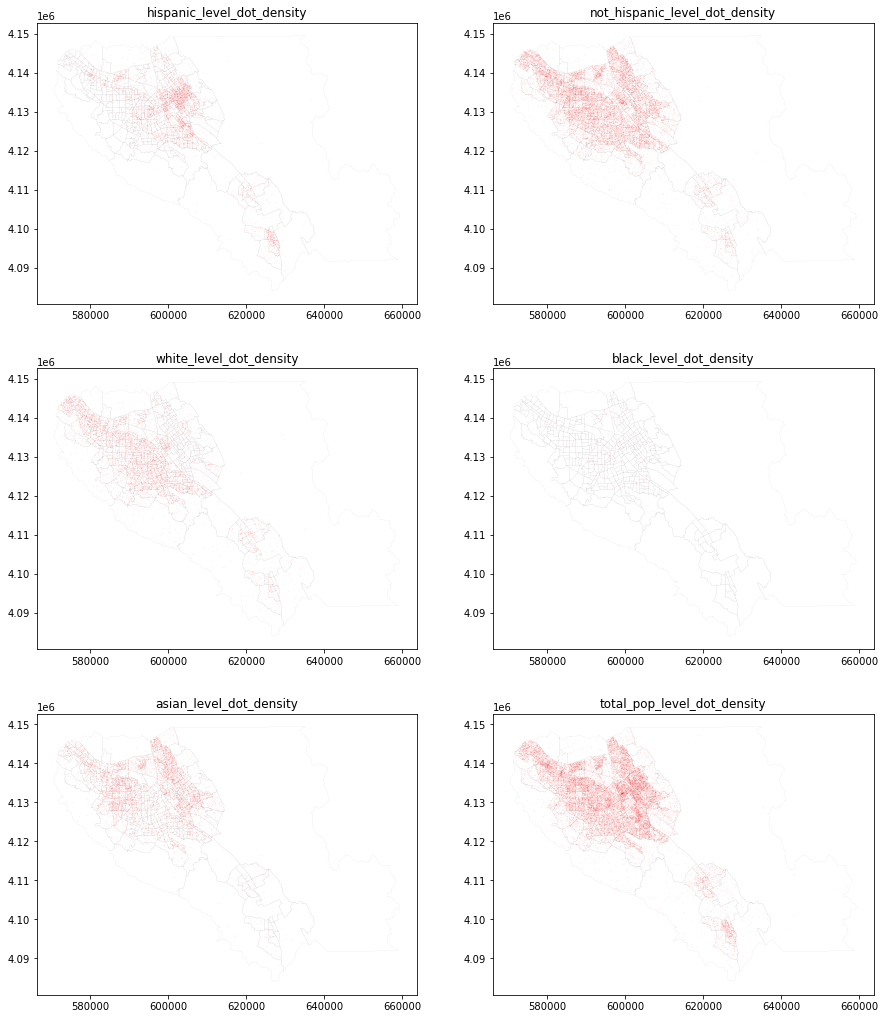

In [13]:
#Plotting
#income level
fig, ax = plt.subplots(figsize=(10,10))
demo_blocks_geo_project.plot(ax=ax, color='none', edgecolor='gray', linewidth=.05)
figure_income_points=income_points.plot(ax=ax, color='r', markersize=.0002, alpha=0.2)
figure_income_points.set_title('income_level_dot_density')

#Race
point_figures=[income_points, hispanic_points, not_hispanic_points, white_points, black_points, asian_points, total_pop_points]
fig, ax = plt.subplots(3,2, figsize=(15,18))
x=0
for i in np.arange(3):
    for j in np.arange(2):
        x=x+1
        demo_blocks_geo_project.plot(ax=ax[i,j], color='none', edgecolor='gray', linewidth=.05)
        point_figures[x].plot(ax=ax[i,j],color='r', markersize=.01, alpha=0.2)
        ax[i,j].set_title(normalized_demographics[x].strip('_sqmi') + '_level_dot_density')

Text(0.5, 1.0, 'income_level_interpolate')

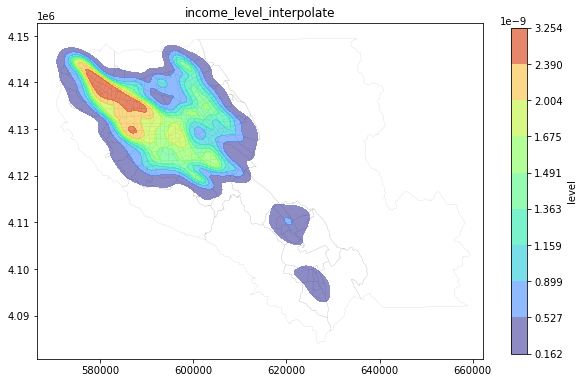

In [14]:
#Plotting using Interpolate
#Income
fig, ax = plt.subplots(figsize=(10,10))
demo_blocks_geo_project.plot(ax=ax, color='none', edgecolor='gray', linewidth=.1)
figure_income_interpolate=sns.kdeplot(
    x=income_points['geometry'].x, y=income_points['geometry'].y,
    cmap='turbo', fill=True, alpha=0.6,legend=True, cbar=True,
                   cbar_kws={'shrink':0.6,'label': "level",'orientation': "vertical",'pad':0.05})
figure_income_interpolate.set_title('income_level_interpolate')

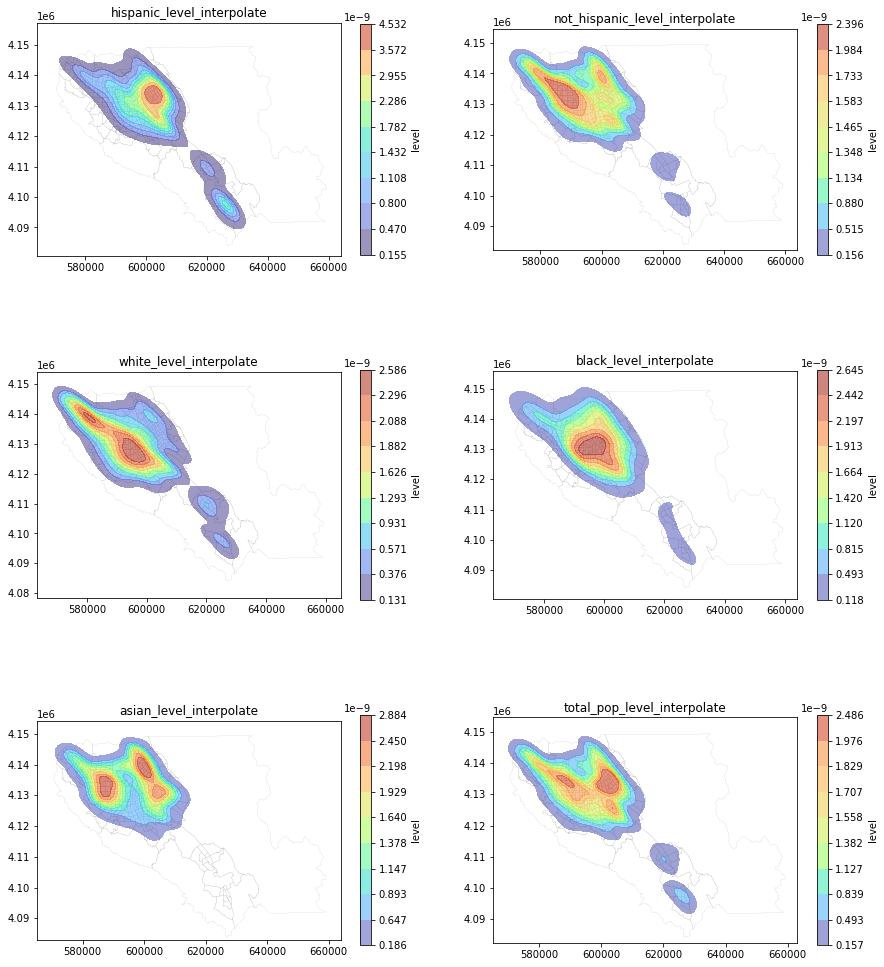

In [15]:
#Race
fig, ax = plt.subplots(3,2, figsize=(15,18))
x=0
for i in np.arange(3):
    for j in np.arange(2):
        x=x+1
        demo_blocks_geo_project.plot(ax=ax[i,j], color='none', edgecolor='gray', linewidth=.1)
        sns.kdeplot(ax=ax[i,j],x=point_figures[x]['geometry'].x, y=point_figures[x]['geometry'].y, cmap='turbo', fill=True, alpha=0.5,cbar=True,
                   cbar_kws={'shrink':0.8,'label': "level",'orientation': "vertical",'pad':0.05})
        ax[i,j].set_title(normalized_demographics[x].strip('_sqmi') + '_level_interpolate')



#### 2.Crimes (Geocoding)



In [5]:
#Geocoding Crimes
#Read Crime Data from APIs
crimes_url='https://data.sccgov.org/resource/n9u6-aijz.json'
crimes_response=requests.get(crimes_url)
crimes_all=pd.DataFrame.from_dict(crimes_response.json())
crimes_all['address']=crimes_all['address_1']+', '+crimes_all['city']+ ', California'
crimes_address=crimes_all['address'].to_list()

In [6]:
#Geocoding
with open("mapbox_api_key.json", 'r') as f:
    key_file = f.read()

my_api_key = json.loads(key_file)['key']
geocoder = Geocoder(access_token=my_api_key)

crime = pd.DataFrame(index=[],columns=['address','lat','lon'])
addrs=crimes_address

for i in range(len(addrs)):
    geoadress=geocoder.forward(str(addrs[i]), limit = 1).geojson()['features'][0]['geometry']['coordinates']
    crime.loc[i, 'address']=addrs[i]
    crime.loc[i, 'lon']=geoadress[0]
    crime.loc[i, 'lat']=geoadress[1]

crime_cleaned=crime.loc[crime['lon']<-121.1].loc[crime['lon']>-122.2].loc[crime['lat']<37.5].loc[crime['lat']>36.8]

In [7]:
crime_cleaned.reset_index()

index                                            address       lat  \
0        0  25600 Block W FREMONT RD, Santa Clara County, ...     37.36   
1        1   TENNANT AV (D2) , Santa Clara County, California  37.24889   
2        2  12300 Block BLOCK EL MONTE RD, Santa Clara Cou...   37.3571   
3        3         CONDIT RD , Santa Clara County, California  37.13395   
4        4  14000 Block LUCIAN AV, Santa Clara County, Cal...     37.36   
..     ...                                                ...       ...   
991    995  1400 Block E MIDDLE AV, Santa Clara County, Ca...  37.10532   
992    996     N 2ND ST (D2) , Santa Clara County, California   37.3272   
993    997  700 Block BLOCK S ABEL ST, Santa Clara County,...     37.36   
994    998  95 Block BLOCK UNIVERSITY AV, Santa Clara Coun...     37.36   
995    999       COLUMBET AV , Santa Clara County, California  37.08956   

            lon  
0       -121.97  
1   -121.774087  
2    -122.12677  
3   -121.632425  
4       -121.97  
..          ...  
991  -121.60681  
992 -121.882875  
993     -121.97  
994     -121.97  
995  -121.59105  

[996 rows x 4 columns]

In [8]:
#Turn LAT/LON to X/Y
lon_list=crime_cleaned['lon'].to_list()
lat_list=crime_cleaned['lat'].to_list()

j=0
xy_coor = []
for i in lon_list:
    xy_coor.append(utm.from_latlon(lat_list[j],i))
    j=j+1

xy=pd.DataFrame(xy_coor)
xy=xy.rename(columns={0:'x',1:'y',2:'zone'})
xy.head()

x             y  zone  3
0  591212.787370  4.135307e+06    10  S
1  608722.556775  4.123187e+06    10  S
2  577332.510799  4.134845e+06    10  S
3  621470.819604  4.110607e+06    10  S
4  591212.787370  4.135307e+06    10  S

In [9]:
#Build Geodataframe
crime_points = gpd.GeoDataFrame(
    xy, geometry=gpd.points_from_xy(xy.x, xy.y))
crime_points_projected=crime_points.set_crs("epsg:26910")

In [10]:
crime_points.to_csv('crimes.csv')

Text(0.5, 1.0, 'crime_points')

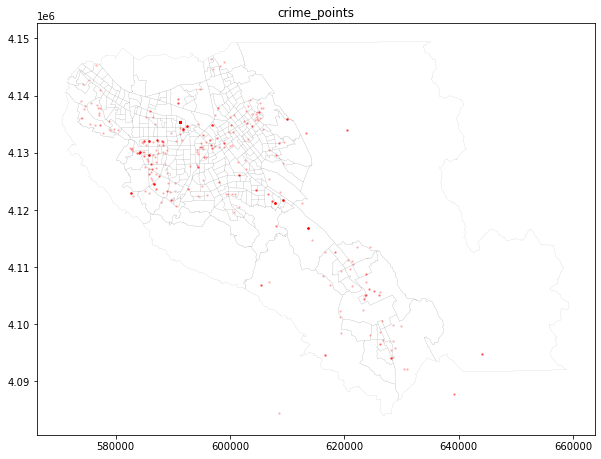

In [20]:
#Plotting
fig, ax = plt.subplots(figsize=(10,10))
demo_blocks_geo_project.plot(ax=ax, color='none', edgecolor='gray', linewidth=.1)
figure_crime_points=crime_points_projected.plot(ax=ax, color='r', markersize=2, alpha=0.2)
figure_crime_points.set_title('crime_points')

Text(0.5, 1.0, 'crime_level_interpolate')

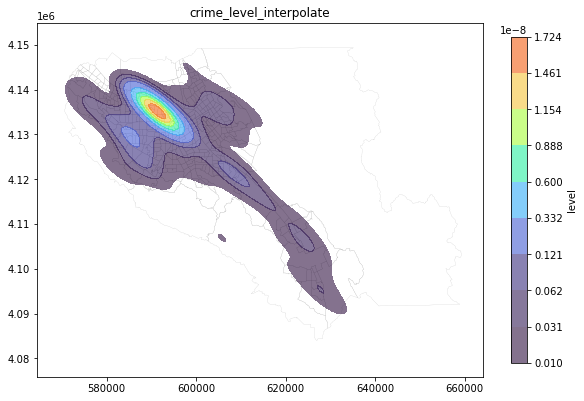

In [21]:
#Interpolate
fig, ax = plt.subplots(figsize=(10,10))
demo_blocks_geo_project.plot(ax=ax, color='none', edgecolor='gray', linewidth=.1)
figure_crime_interpolate=sns.kdeplot(
    x=crime_points_projected['geometry'].x, y=crime_points_projected['geometry'].y,
    cmap='turbo', fill=True, alpha=0.6,legend=True, cbar=True,vmax=2.01e-8,
                   cbar_kws={'shrink':0.6,'label': "level",'orientation': "vertical",'pad':0.05})
figure_crime_interpolate.set_title('crime_level_interpolate')

#### 3.Housing Prices (Web Scraping + Geocoding)

In [58]:
#Scrape From Realtor.com using API
url="https://api.webscrapingapi.com/v1"
page=[]
for k in np.arange(30):
    pagek='https://www.realtor.com/realestateandhomes-search/Santa-Clara-County_CA'+'/pg-'+k.astype('str')
    page.append(pagek)

responses=[]
for m in np.arange(30):
    reponsem='reponse'+m.astype('str')
    responses.append(reponsem)
    
contents=[]
for n in np.arange(30):
    content='content'+n.astype('str')
    contents.append(content)
    
for i in np.arange(30):
    params={
    "api_key": "yKUskmBuReXD3E3vWzcLf5sqsTE1jaIr",
    "url": page[i]}
    
    responses[i] = requests.request("GET", url, params=params)
    contents[i] = responses[i].text

    
prices=[]
beds=[]
baths=[]
sizes=[]
addresses=[]

soups=[]
for o in np.arange(30):
    soupo='soup'+o.astype('str')
    soups.append(soupo)

for k in np.arange(30):
    soups[k] = BeautifulSoup(contents[k], features='html.parser')

for soupi in soups:
    for element in soupi.findAll('li', attrs={'class': 'component_property-card'}):
        price = element.find('span', attrs={'data-label': 'pc-price'})
        bed = element.find('li', attrs={'data-label': 'pc-meta-beds'})
        bath = element.find('li', attrs={'data-label': 'pc-meta-baths'})
        size = element.find('li', attrs={'data-label': 'pc-meta-sqft'})
        address = element.find('div', attrs={'data-label': 'pc-address'})
        
        if bed and bath:
            nr_beds = bed.find('span', attrs={'data-label': 'meta-value'})
            nr_baths = bath.find('span', attrs={'data-label': 'meta-value'})
        
        if nr_beds and float(nr_beds.text) >= 1:
            beds.append(nr_beds.text)
            baths.append(nr_baths.text)

            if price and price.text:
                prices.append(price.text)
            else:
                    prices.append('No display data')
            
            if size and size.text:
                sizes.append(size.text)
            else:
                sizes.append('No display data')
                
            if address and address.text:
                addresses.append(address.text)
            else:
                addresses.append('No display data')

In [59]:
df3 = pd.DataFrame({'Address': addresses, 'Price': prices, 'Beds': beds, 'Baths': baths, 'Sizes': sizes})

In [63]:
housing_cleaned=df3[(df3['Address']!= 'No display data')&(df3['Price']!= 'No display data')&(df3['Sizes']!= 'No display data')]
housing_cleaned.to_csv('housing_santa_clara_final.csv')
housing_cleaned

Address       Price Beds  \
0                693 Barrett Ave, Morgan Hill, CA 95037    $560,000    4   
1     133 Mountain Springs Dr Unit 133, San Jose, CA...    $375,000    3   
2                      7951 Carmel St, Gilroy, CA 95020    $729,000    3   
4                     854 N 12th St, San Jose, CA 95112  $1,050,000    2   
5                    1849 Forest Ct, Milpitas, CA 95035    $998,888    3   
...                                                 ...         ...  ...   
1338               312 Blairbeth Dr, San Jose, CA 95119  $1,165,000    3   
1339                2307 Newhall St, San Jose, CA 95128  $1,199,888    2   
1340               465 McCamish Ave, San Jose, CA 95123  $1,398,000    5   
1341           2170 Cabrillo Ave, Santa Clara, CA 95050  $1,475,000    3   
1342                 752 Menker Ave, San Jose, CA 95128  $1,398,000    3   

     Baths      Sizes  
0      2.5  1,897sqft  
1        2  1,658sqft  
2        2  1,528sqft  
4        2  1,300sqft  
5        2  1,215sqft  
...    ...        ...  
1338   1.5  1,014sqft  
1339     2  1,000sqft  
1340     3  1,380sqft  
1341     2  1,181sqft  
1342     2  1,206sqft  

[1159 rows x 5 columns]

In [64]:
#Geocoding 02
housing_address=housing_cleaned['Address'].to_list()

with open("mapbox_api_key.json", 'r') as f:
    key_file = f.read()

my_api_key = json.loads(key_file)['key']
geocoder = Geocoder(access_token=my_api_key)

housing = pd.DataFrame(index=[],columns=['address','lat','lon'])
addrs=housing_address

for i in range(len(addrs)):
    geoadress=geocoder.forward(str(addrs[i]), limit = 1).geojson()['features'][0]['geometry']['coordinates']
    housing.loc[i, 'address']=addrs[i]
    housing.loc[i, 'lon']=geoadress[0]
    housing.loc[i, 'lat']=geoadress[1]

housing_geocoded=housing.loc[housing['lon']<-121.1].loc[housing['lon']>-122.2].loc[housing['lat']<37.5].loc[housing['lat']>36.8]

In [66]:
housing_geocoded.to_csv('housing_with_coor.csv')

In [26]:
housing_coor=pd.read_csv('housing_with_coor.csv')
housing_coor.reset_index

<bound method DataFrame.reset_index of       Unnamed: 0                                            address  \
0              0             693 Barrett Ave, Morgan Hill, CA 95037   
1              1  133 Mountain Springs Dr Unit 133, San Jose, CA...   
2              2                   7951 Carmel St, Gilroy, CA 95020   
3              3                  854 N 12th St, San Jose, CA 95112   
4              4                 1849 Forest Ct, Milpitas, CA 95035   
...          ...                                                ...   
1154        1154               312 Blairbeth Dr, San Jose, CA 95119   
1155        1155                2307 Newhall St, San Jose, CA 95128   
1156        1156               465 McCamish Ave, San Jose, CA 95123   
1157        1157           2170 Cabrillo Ave, Santa Clara, CA 95050   
1158        1158                 752 Menker Ave, San Jose, CA 95128   

            lat         lon  
0     37.121650 -121.633860  
1     37.280390 -121.864500  
2     37.012880 -1

In [27]:
#Turn LAT/LON to X/Y
housing_lon_list=housing_coor['lon'].to_list()
houisng_lat_list=housing_coor['lat'].to_list()

o=0
housing_xy_coor = []
for i in housing_lon_list:
    housing_xy_coor.append(utm.from_latlon(houisng_lat_list[o],i))
    o=o+1

housing_xy=pd.DataFrame(housing_xy_coor)
housing_xy=housing_xy.rename(columns={0:'x',1:'y',2:'zone'})
housing_xy.head()

x             y  zone  3
0  621362.996494  4.109241e+06    10  S
1  600661.902772  4.126582e+06    10  S
2  626326.515128  4.097244e+06    10  S
3  598208.763159  4.135176e+06    10  S
4  596656.667605  4.140252e+06    10  S

In [28]:
#Combine Dataframes
housing_prices=pd.read_csv('housing_santa_clara_final.csv')
housing_merged=pd.merge(housing_prices,housing_xy,how='outer',left_index=True, right_index=True)

#Data Cleaning
housing_merged['price_num']=housing_merged['Price'].str.replace('$','',regex=True).str.replace('From','',regex=True).str.replace(',','',regex=True).astype(int)
housing_merged['Beds_num']=housing_merged['Beds'].astype(str).str.replace('+','',regex=True).astype(float)
housing_merged['Baths_num']=housing_merged['Baths'].astype(str).str.replace('+','',regex=True).astype(float)
housing_merged['Size_num']=housing_merged['Sizes'].str.replace(',','',regex=True).str.replace('sqft','',regex=True).astype(float)
housing_merged.to_csv('housing_merged.csv')
housing_merged

Unnamed: 0                                            Address  \
0              0             693 Barrett Ave, Morgan Hill, CA 95037   
1              1  133 Mountain Springs Dr Unit 133, San Jose, CA...   
2              2                   7951 Carmel St, Gilroy, CA 95020   
3              4                  854 N 12th St, San Jose, CA 95112   
4              5                 1849 Forest Ct, Milpitas, CA 95035   
...          ...                                                ...   
1154        1338               312 Blairbeth Dr, San Jose, CA 95119   
1155        1339                2307 Newhall St, San Jose, CA 95128   
1156        1340               465 McCamish Ave, San Jose, CA 95123   
1157        1341           2170 Cabrillo Ave, Santa Clara, CA 95050   
1158        1342                 752 Menker Ave, San Jose, CA 95128   

           Price  Beds Baths      Sizes              x             y  zone  3  \
0       $560,000     4   2.5  1,897sqft  621362.996494  4.109241e+06    10  S   
1       $375,000     3     2  1,658sqft  600661.902772  4.126582e+06    10  S   
2       $729,000     3     2  1,528sqft  626326.515128  4.097244e+06    10  S   
3     $1,050,000     2     2  1,300sqft  598208.763159  4.135176e+06    10  S   
4       $998,888     3     2  1,215sqft  596656.667605  4.140252e+06    10  S   
...          ...   ...   ...        ...            ...           ...   ... ..   
1154  $1,165,000     3   1.5  1,014sqft  607567.302067  4.120410e+06    10  S   
1155  $1,199,888     2     2  1,000sqft  593544.005907  4.132886e+06    10  S   
1156  $1,398,000     5     3  1,380sqft  604807.448551  4.121567e+06    10  S   
1157  $1,475,000     3     2  1,181sqft  591880.455486  4.135159e+06    10  S   
1158  $1,398,000     3     2  1,206sqft  595602.891193  4.130163e+06    10  S   

      price_num  Beds_num  Baths_num  Size_num  
0        560000       4.0        2.5    1897.0  
1        375000       3.0        2.0    1658.0  
2        729000       3.0        2.0    1528.0  
3       1050000       2.0        2.0    1300.0  
4        998888       3.0        2.0    1215.0  
...         ...       ...        ...       ...  
1154    1165000       3.0        1.5    1014.0  
1155    1199888       2.0        2.0    1000.0  
1156    1398000       5.0        3.0    1380.0  
1157    1475000       3.0        2.0    1181.0  
1158    1398000       3.0        2.0    1206.0  

[1159 rows x 14 columns]

In [29]:
#Build Geodataframe
housing_points = gpd.GeoDataFrame(
    housing_merged, geometry=gpd.points_from_xy(housing_merged.x, housing_merged.y))
housing_points_projected=housing_points.set_crs("epsg:26910")

Text(0.5, 1.0, 'housing_points')

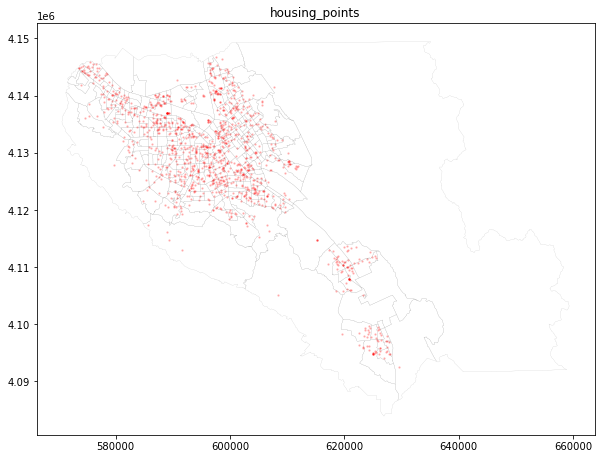

In [30]:
fig, ax = plt.subplots(figsize=(10,10))
demo_blocks_geo_project.plot(ax=ax, color='none', edgecolor='gray', linewidth=.1)
housing_points_projected_figure=housing_points_projected.plot(ax=ax, color='r', markersize=2, alpha=0.2)
housing_points_projected_figure.set_title('housing_points')

#### 4.Parks (Shapefiles)

Text(0.5, 1.0, 'park_points')

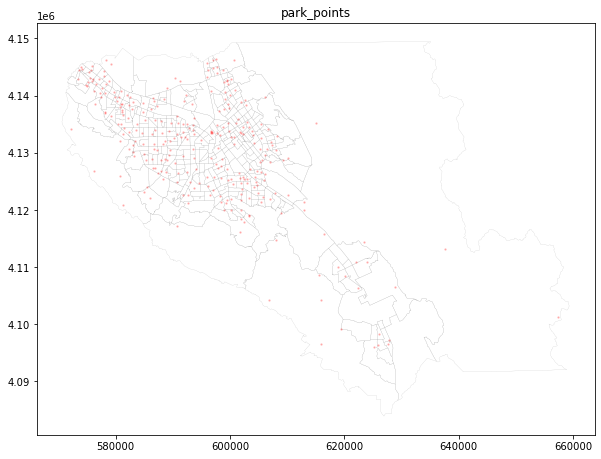

In [31]:
#read park shapefiles
park=gpd.read_file("park.shp")
park_project=park.to_crs("epsg:26910")

fig, ax = plt.subplots(figsize=(10,10))
demo_blocks_geo_project.plot(ax=ax, color='none', edgecolor='gray', linewidth=.1)
park_project_figure=park_project.plot(ax=ax, color='r', markersize=2, alpha=0.2)
park_project_figure.set_title('park_points')

In [32]:
park_project

address  city     editor  date_lastu    time_lastu   latitude   longitude  \
0      None  None  ISD - GIS  2011-09-14  00:00:00.000  37.345192 -121.827989   
1      None  None  ISD - GIS  2011-09-14  00:00:00.000  37.420058 -121.873051   
2      None  None  ISD - GIS  2011-09-14  00:00:00.000  37.453678 -122.104850   
3      None  None  ISD - GIS  2011-09-14  00:00:00.000  37.388243 -121.874145   
4      None  None  ISD - GIS  2011-09-14  00:00:00.000  37.319050 -122.021297   
..      ...   ...        ...         ...           ...        ...         ...   
284    None  None  ISD - GIS  2011-09-14  00:00:00.000  37.458406 -121.896831   
285    None  None  ISD - GIS  2011-09-14  00:00:00.000  37.135894 -121.626576   
286    None  None  ISD - GIS  2011-09-14  00:00:00.000  37.287440 -121.895775   
287    None  None  ISD - GIS  2011-09-14  00:00:00.000  37.246279 -121.851046   
288    None  None  ISD - GIS  2011-09-14  00:00:00.000  37.333791 -121.809102   

              notes  objectid               placename placetype poicatagor  \
0    Not Determined      78.0            Cassell Park      Park    Leisure   
1    Not Determined     249.0            Sinnott Park      Park    Leisure   
2    Not Determined      68.0  Byxbee Recreation Area      Park    Leisure   
3    Not Determined     117.0         Flickering Park      Park    Leisure   
4    Not Determined     284.0             Wilson Park      Park    Leisure   
..              ...       ...                     ...       ...        ...   
284  Not Determined     145.0      Higuera Adobe Park      Park    Leisure   
285  Not Determined     200.0          Nordstrom Park      Park    Leisure   
286  Not Determined     268.0         Wallenberg Park      Park    Leisure   
287  Not Determined      69.0            Cahalan Park      Park    Leisure   
288  Not Determined     159.0    Lake Cunningham Park      Park    Leisure   

    source symbologys    uniqueid   zip                        geometry  
0     ESRI     <Null>   832010POS  None  POINT (603809.713 4133810.890)  
1     ESRI     <Null>  2542010POS  None  POINT (599719.053 4142068.434)  
2     ESRI     <Null>   732010POS  None  POINT (579172.190 4145578.295)  
3     ESRI     <Null>  1222010POS  None  POINT (599664.361 4138537.476)  
4     ESRI     <Null>  2892010POS  None  POINT (586717.290 4130715.624)  
..     ...        ...         ...   ...                             ...  
284   ESRI     <Null>  1502010POS  None  POINT (597564.997 4146298.066)  
285   ESRI     <Null>  2052010POS  None  POINT (621987.418 4110830.394)  
286   ESRI     <Null>  2732010POS  None  POINT (597880.360 4127331.233)  
287   ESRI     <Null>   742010POS  None  POINT (601900.758 4122811.879)  
288   ESRI     <Null>  1642010POS  None  POINT (605498.622 4132566.906)  

[289 rows x 17 columns]

#### 5.Tech Companies (Shapefiles)

Text(0.5, 1.0, 'tech_points')

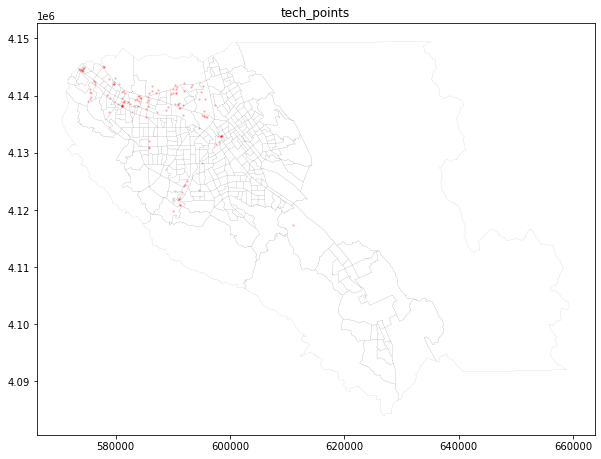

In [33]:
#read tech shapefiles
tech=gpd.read_file("tech.shp")
tech_project=tech.to_crs("epsg:26910")

fig, ax = plt.subplots(figsize=(10,10))
demo_blocks_geo_project.plot(ax=ax, color='none', edgecolor='gray', linewidth=.1)
tech_project_figure=tech_project.plot(ax=ax, color='r', markersize=2, alpha=0.2)
tech_project_figure.set_title('tech_points')

#### 6.Hospitals (Shapefiles)

Text(0.5, 1.0, 'hospital_points')

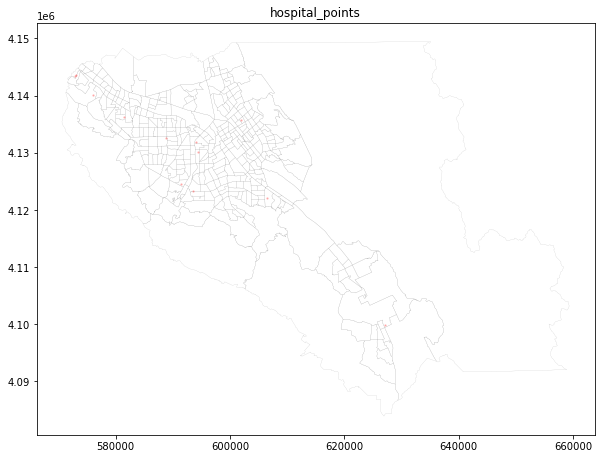

In [34]:
#read hospital shapefiles
hospital=gpd.read_file("Hospitals/hospital.shp")
hospital_project=hospital.to_crs("epsg:26910")

fig, ax = plt.subplots(figsize=(10,10))
demo_blocks_geo_project.plot(ax=ax, color='none', edgecolor='gray', linewidth=.1)
hospital_project_figure=hospital_project.plot(ax=ax, color='r', markersize=2, alpha=0.2)
hospital_project_figure.set_title('hospital_points')

#### 7.Schools (Shapefiles)

Text(0.5, 1.0, 'school_points')

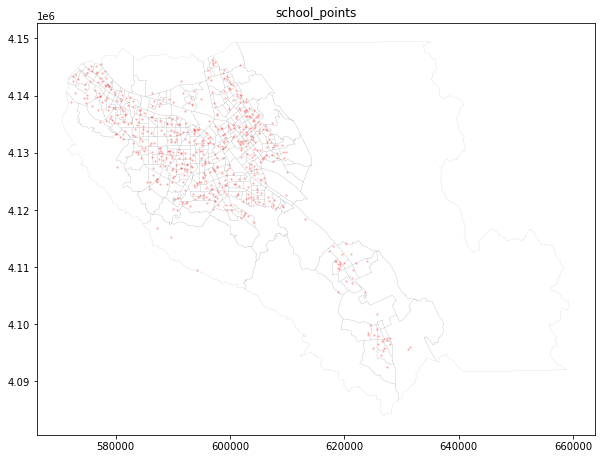

In [35]:
#read school shapefiles
school=gpd.read_file("SchoolsAreas/School.shp")
school_project=school.to_crs("epsg:26910")
school_project_centroid=school_project.centroid

fig, ax = plt.subplots(figsize=(10,10))
demo_blocks_geo_project.plot(ax=ax, color='none', edgecolor='gray', linewidth=.1)
school_project_figure=school_project_centroid.plot(ax=ax, color='r', markersize=2, alpha=0.2)
school_project_figure.set_title('school_points')

In [36]:
school_project_centroid.geometry.x

0      595796.388250
1      625825.507271
2      593656.608616
3      620247.560637
4      588990.662071
           ...      
565    603022.682311
566    603193.054769
567    574908.900400
568    572155.163676
569    594997.388901
Length: 570, dtype: float64

In [37]:
o=0
school_ll_coor = []
for i in np.arange(570):
    school_ll_coor.append(utm.to_latlon(school_project_centroid.geometry.x[i], school_project_centroid.geometry.y[i],10,'U'))
    o=o+1

In [38]:
school_xy=pd.DataFrame(school_ll_coor)
school_xy=school_xy.rename(columns={0:'y',1:'x'})
school_xy.head()

y           x
0  37.256579 -121.919723
1  37.018984 -121.585538
2  37.343771 -121.942632
3  37.107320 -121.646671
4  37.262615 -121.996388

#### 8.Rails (Shapefiles)

Text(0.5, 1.0, 'rail_points')

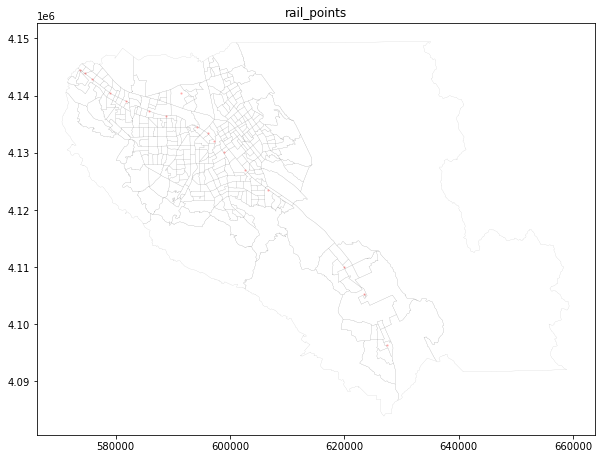

In [39]:
#read rail shapefiles
rail=gpd.read_file("RailroadStations/rail.shp")
rail_project=rail.to_crs("epsg:26910")

fig, ax = plt.subplots(figsize=(10,10))
demo_blocks_geo_project.plot(ax=ax, color='none', edgecolor='gray', linewidth=.1)
rail_project_figure=rail_project.plot(ax=ax, color='r', markersize=2, alpha=0.2)
rail_project_figure.set_title('rail_points')

## II-Data Processing + Analysis(i)

#### 1. Network Analysis (Pandana)

In [24]:
#Basic Network
network = osm.pdna_network_from_bbox(36.8, -122.2, 37.5, -121.1)  # Santa Clara, CA
network.nodes_df.to_csv('nodes_SC.csv')
network.edges_df.to_csv('edges_SC.csv')
nodes = pd.read_csv('nodes_SC.csv', index_col=0)
edges = pd.read_csv('edges_SC.csv', index_col=[0,1])
network = pandana.Network(nodes['x'], nodes['y'], 
                          edges['from'], edges['to'], edges[['distance']])

Requesting network data within bounding box from Overpass API in 4 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](36.80000000,-122.20001486,37.15629766,-121.64744886);>;);out;'}"
Downloaded 41,778.4KB from www.overpass-api.de in 10.18 seconds
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](37.15127925,-122.20001486,37.50128049,-121.64115963);>;);out;'}"
Downloaded 149,754.8KB from www.overpass-api.de in 28.58 seconds
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pe

In [40]:
park_nodes = network.get_node_ids(park_project.longitude,park_project.latitude)
tech_nodes = network.get_node_ids(tech_project.Longitude,tech_project.Latitude)
school_nodes = network.get_node_ids(school_xy.x,school_xy.y)
hospital_nodes = network.get_node_ids(hospital_project.longitude,hospital_project.latitude)
rail_nodes = network.get_node_ids(rail_project.longitude,rail_project.latitude)

network.set(park_nodes, name = 'parks')
network.set(tech_nodes, name = 'tech')
network.set(school_nodes, name = 'school')
network.set(hospital_nodes, name = 'hospital')
network.set(rail_nodes, name = 'rail')

In [41]:
# Network Aggregation
accessibility_park = network.aggregate(
    distance=1500,
    type='count',  # could also do mean, sum, percentile, like pandas aggregation functions
    decay='flat',  # can apply exponential or linear decay for sum/mean 
    name='parks'
)

accessibility_tech = network.aggregate(
    distance=3000,
    type='count',  # could also do mean, sum, percentile, like pandas aggregation functions
    decay='flat',  # can apply exponential or linear decay for sum/mean 
    name='tech'
)

accessibility_school = network.aggregate(
    distance=1500,
    type='count',  # could also do mean, sum, percentile, like pandas aggregation functions
    decay='flat',  # can apply exponential or linear decay for sum/mean 
    name='school'
)

accessibility_hospital = network.aggregate(
    distance=3000,
    type='count',  # could also do mean, sum, percentile, like pandas aggregation functions
    decay='flat',  # can apply exponential or linear decay for sum/mean 
    name='hospital'
)

accessibility_rail = network.aggregate(
    distance=3000,
    type='count',  # could also do mean, sum, percentile, like pandas aggregation functions
    decay='flat',  # can apply exponential or linear decay for sum/mean 
    name='rail'
)

In [42]:
accessibility=[accessibility_park,accessibility_tech,accessibility_school,accessibility_hospital,accessibility_rail]

In [43]:
network.nodes_df

x          y
id                               
25457919   -121.548457  36.930232
25457938   -121.553913  37.007868
25457939   -121.550781  37.002077
26027651   -122.102672  37.418131
26027653   -122.108639  37.407976
...                ...        ...
9726790960 -121.763962  36.906939
9726790965 -121.763419  36.907001
9726790966 -121.763723  36.907026
9726790967 -121.763667  36.906925
9727906228 -121.939186  37.260596

[351380 rows x 2 columns]

In [44]:
#Turn LAT/LON to X/Y
network_nodes_lon_list=network.nodes_df.x.to_list()
network_nodes_lat_list=network.nodes_df.y.to_list()

o=0
network_xy_coor = []
for i in network_nodes_lon_list:
    network_xy_coor.append(utm.from_latlon(network_nodes_lat_list[o],i))
    o=o+1

network_xy=pd.DataFrame(network_xy_coor)
network_xy=network_xy.rename(columns={0:'x',1:'y',2:'zone'})
network_xy.head()

x             y  zone  3
0  629274.329992  4.088117e+06    10  S
1  628657.690661  4.096723e+06    10  S
2  628946.115683  4.096084e+06    10  S
3  579402.250828  4.141636e+06    10  S
4  578884.867009  4.140505e+06    10  S

In [45]:
acc = gpd.GeoDataFrame(
    network_xy, geometry=gpd.points_from_xy(network_xy.x, network_xy.y))
acc_projected=acc.set_crs("epsg:26910")

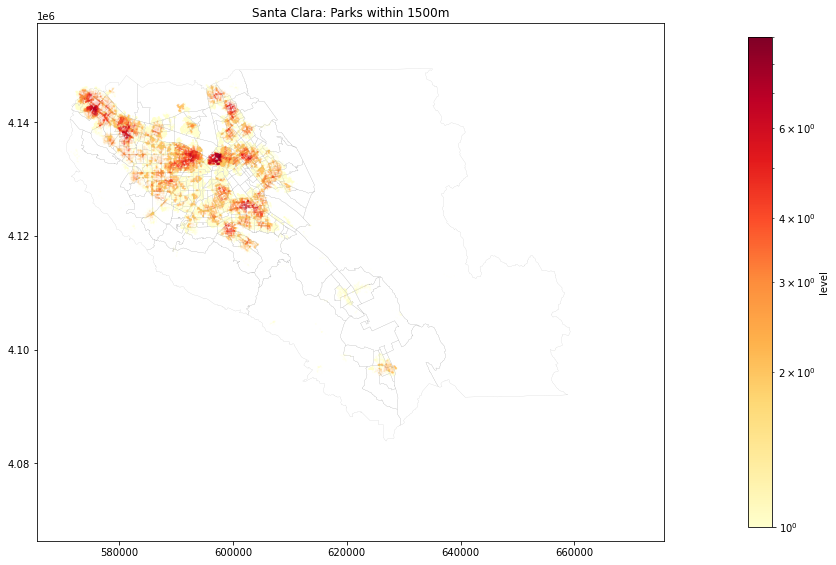

In [90]:
fig, ax = plt.subplots(figsize=(15,15))
plt.title('Santa Clara: Parks within 1500m')

demo_blocks_geo_project.plot(ax=ax, color='none', edgecolor='gray', linewidth=.1)
plt.scatter(acc_projected.x, acc_projected.y, 
            c=accessibility[0], s=0.001, cmap='YlOrRd',
            norm=matplotlib.colors.LogNorm())

cb = plt.colorbar(shrink=0.6,label="level",orientation= "vertical",pad=0.1)

plt.show()

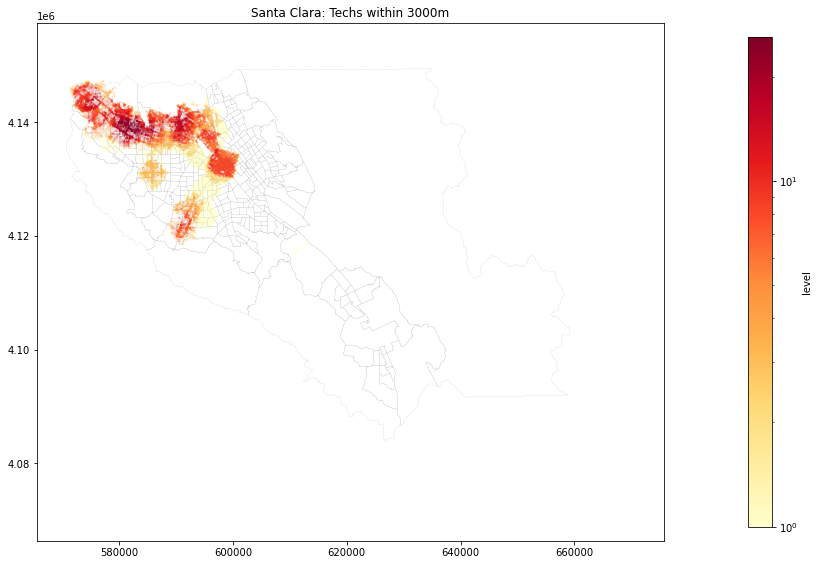

In [91]:
fig, ax = plt.subplots(figsize=(15,15))
plt.title('Santa Clara: Techs within 3000m')

demo_blocks_geo_project.plot(ax=ax, color='none', edgecolor='gray', linewidth=.1)
plt.scatter(acc_projected.x, acc_projected.y, 
            c=accessibility[1], s=0.001, cmap='YlOrRd',
            norm=matplotlib.colors.LogNorm())

cb = plt.colorbar(shrink=0.6,label="level",orientation= "vertical",pad=0.1)

plt.show()

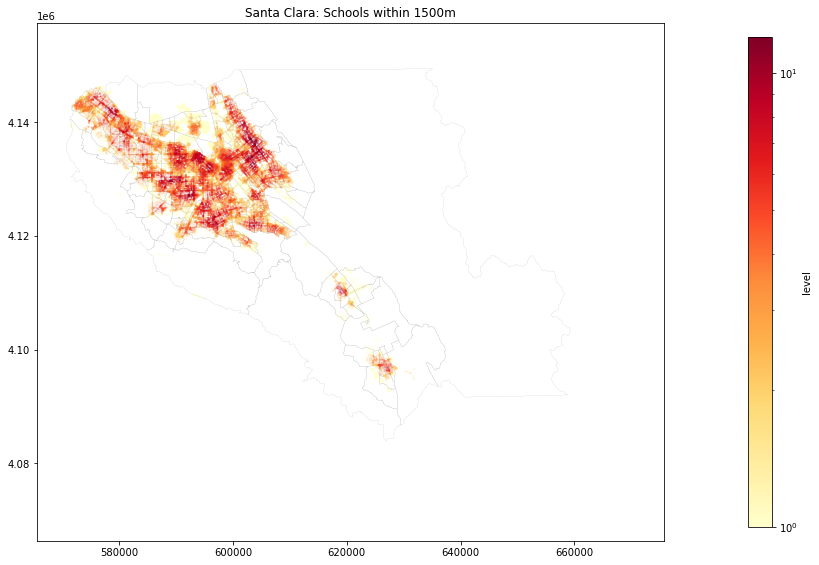

In [92]:
fig, ax = plt.subplots(figsize=(15,15))
plt.title('Santa Clara: Schools within 1500m')

demo_blocks_geo_project.plot(ax=ax, color='none', edgecolor='gray', linewidth=.1)
plt.scatter(acc_projected.x, acc_projected.y, 
            c=accessibility[2], s=0.001, cmap='YlOrRd',
            norm=matplotlib.colors.LogNorm())

cb = plt.colorbar(shrink=0.6,label="level",orientation= "vertical",pad=0.1)

plt.show()

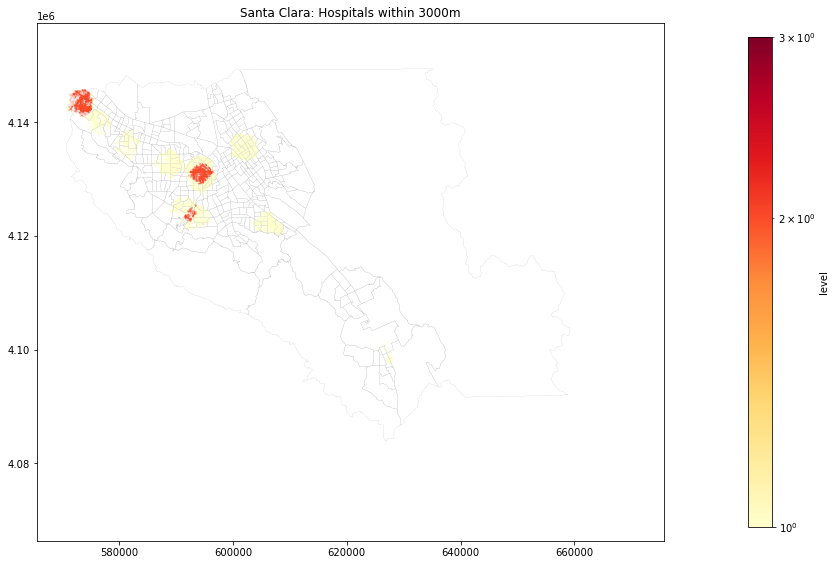

In [93]:
fig, ax = plt.subplots(figsize=(15,15))
plt.title('Santa Clara: Hospitals within 3000m')

demo_blocks_geo_project.plot(ax=ax, color='none', edgecolor='gray', linewidth=.1)
plt.scatter(acc_projected.x, acc_projected.y, 
            c=accessibility[3], s=0.001, cmap='YlOrRd',
            norm=matplotlib.colors.LogNorm())

cb = plt.colorbar(shrink=0.6,label="level",orientation= "vertical",pad=0.1)

plt.show()

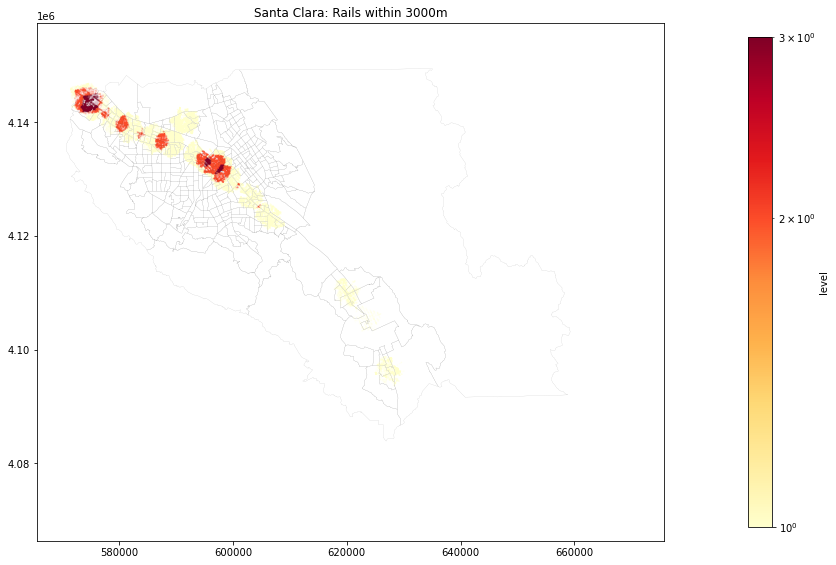

In [94]:
fig, ax = plt.subplots(figsize=(15,15))
plt.title('Santa Clara: Rails within 3000m')

demo_blocks_geo_project.plot(ax=ax, color='none', edgecolor='gray', linewidth=.1)
plt.scatter(acc_projected.x, acc_projected.y, 
            c=accessibility[4], s=0.001, cmap='YlOrRd',
            norm=matplotlib.colors.LogNorm())

cb = plt.colorbar(shrink=0.6,label="level",orientation= "vertical",pad=0.1)

plt.show()

#### 2. Accessibility Data Processing (Table Joints using different weights of nodes)

In [95]:
#Accessibility Data
acc_park=pd.merge(network.nodes_df,accessibility[0].to_frame(),how='outer',left_index=True,right_index=True)
acc_park=acc_park.rename(columns={0:'acc_park_weight'})

acc_tech=pd.merge(acc_park,accessibility[1].to_frame(),how='outer',left_index=True,right_index=True)
acc_tech=acc_tech.rename(columns={0:'acc_tech_weight'})

acc_school=pd.merge(acc_tech,accessibility[2].to_frame(),how='outer',left_index=True,right_index=True)
acc_school=acc_school.rename(columns={0:'acc_school_weight'})

acc_hospital=pd.merge(acc_school,accessibility[3].to_frame(),how='outer',left_index=True,right_index=True)
acc_hospital=acc_hospital.rename(columns={0:'acc_hospital_weight'})

acc_all=pd.merge(acc_hospital,accessibility[4].to_frame(),how='outer',left_index=True,right_index=True)
acc_all=acc_all.rename(columns={0:'acc_rail_weight'})

In [96]:
acc_all.to_csv('acc_all.csv')
acc_all

x          y  acc_park_weight  acc_tech_weight  \
id                                                                    
25457919   -121.548457  36.930232              0.0              0.0   
25457938   -121.553913  37.007868              2.0              0.0   
25457939   -121.550781  37.002077              0.0              0.0   
26027651   -122.102672  37.418131              1.0             12.0   
26027653   -122.108639  37.407976              2.0              7.0   
...                ...        ...              ...              ...   
9726790960 -121.763962  36.906939              0.0              0.0   
9726790965 -121.763419  36.907001              0.0              0.0   
9726790966 -121.763723  36.907026              0.0              0.0   
9726790967 -121.763667  36.906925              0.0              0.0   
9727906228 -121.939186  37.260596              2.0              3.0   

            acc_school_weight  acc_hospital_weight  acc_rail_weight  
id                                                                   
25457919                  0.0                  0.0              0.0  
25457938                  2.0                  0.0              1.0  
25457939                  0.0                  0.0              1.0  
26027651                  8.0                  0.0              1.0  
26027653                  4.0                  0.0              1.0  
...                       ...                  ...              ...  
9726790960                0.0                  0.0              0.0  
9726790965                0.0                  0.0              0.0  
9726790966                0.0                  0.0              0.0  
9726790967                0.0                  0.0              0.0  
9727906228                6.0                  1.0              0.0  

[351380 rows x 7 columns]

In [97]:
#Turn LAT/LON to X/Y
acc_all_lon_list=acc_all.x.to_list()
acc_all_lat_list=acc_all.y.to_list()

o=0
acc_all_xy_coor = []
for i in acc_all_lon_list:
    acc_all_xy_coor.append(utm.from_latlon(acc_all_lat_list[o],i))
    o=o+1

acc_all_xy=pd.DataFrame(acc_all_xy_coor)
acc_all_xy=acc_all_xy.rename(columns={0:'x_coor',1:'y_coor',2:'zone'})
acc_all_xy.head()

x_coor        y_coor  zone  3
0  629274.329992  4.088117e+06    10  S
1  628657.690661  4.096723e+06    10  S
2  628946.115683  4.096084e+06    10  S
3  579402.250828  4.141636e+06    10  S
4  578884.867009  4.140505e+06    10  S

In [98]:
acc_all=acc_all.reset_index()
acc_xy=pd.merge(acc_all,acc_all_xy,left_index=True,right_index=True)
acc_xy

id           x          y  acc_park_weight  acc_tech_weight  \
0         25457919 -121.548457  36.930232              0.0              0.0   
1         25457938 -121.553913  37.007868              2.0              0.0   
2         25457939 -121.550781  37.002077              0.0              0.0   
3         26027651 -122.102672  37.418131              1.0             12.0   
4         26027653 -122.108639  37.407976              2.0              7.0   
...            ...         ...        ...              ...              ...   
351375  9726790960 -121.763962  36.906939              0.0              0.0   
351376  9726790965 -121.763419  36.907001              0.0              0.0   
351377  9726790966 -121.763723  36.907026              0.0              0.0   
351378  9726790967 -121.763667  36.906925              0.0              0.0   
351379  9727906228 -121.939186  37.260596              2.0              3.0   

        acc_school_weight  acc_hospital_weight  acc_rail_weight  \
0                     0.0                  0.0              0.0   
1                     2.0                  0.0              1.0   
2                     0.0                  0.0              1.0   
3                     8.0                  0.0              1.0   
4                     4.0                  0.0              1.0   
...                   ...                  ...              ...   
351375                0.0                  0.0              0.0   
351376                0.0                  0.0              0.0   
351377                0.0                  0.0              0.0   
351378                0.0                  0.0              0.0   
351379                6.0                  1.0              0.0   

               x_coor        y_coor  zone  3  
0       629274.329992  4.088117e+06    10  S  
1       628657.690661  4.096723e+06    10  S  
2       628946.115683  4.096084e+06    10  S  
3       579402.250828  4.141636e+06    10  S  
4       578884.867009  4.140505e+06    10  S  
...               ...           ...   ... ..  
351375  610114.070172  4.085262e+06    10  S  
351376  610162.339184  4.085270e+06    10  S  
351377  610135.299729  4.085272e+06    10  S  
351378  610140.416892  4.085261e+06    10  S  
351379  594065.414066  4.124309e+06    10  S  

[351380 rows x 12 columns]

In [99]:
from shapely.geometry import Point
geometry = [Point(xy) for xy in zip(acc_xy.x_coor, acc_xy.y_coor)]
acc_xy_geo = gpd.GeoDataFrame(acc_xy, crs='epsg:26910', geometry=geometry)
acc_xy_geo=acc_xy_geo.reset_index()

In [100]:
#Combine all the data
join1=gpd.sjoin(acc_xy_geo,demo_blocks_geo_project,how="right",predicate='intersects')

In [101]:
join1=join1.drop(columns=['index_left','index','id'])

In [102]:
join1

x          y  acc_park_weight  acc_tech_weight  \
0   -121.999522  37.309150              4.0              0.0   
0   -122.006301  37.293208              1.0              0.0   
0   -122.001240  37.309615              3.0              0.0   
0   -122.001534  37.308765              3.0              0.0   
0   -122.002539  37.306074              3.0              0.0   
..          ...        ...              ...              ...   
371 -121.852534  37.397357              2.0              0.0   
371 -121.852898  37.398001              2.0              0.0   
371 -121.852831  37.397861              2.0              0.0   
371 -121.856223  37.395698              1.0              0.0   
371 -121.856543  37.396380              1.0              0.0   

     acc_school_weight  acc_hospital_weight  acc_rail_weight         x_coor  \
0                  9.0                  0.0              0.0  588658.129388   
0                  4.0                  0.0              0.0  588075.942049   
0                  8.0                  0.0              0.0  588505.328935   
0                  8.0                  0.0              0.0  588480.280621   
0                  6.0                  0.0              0.0  588394.307217   
..                 ...                  ...              ...            ...   
371                8.0                  0.0              0.0  601565.064117   
371                8.0                  0.0              0.0  601531.940254   
371                8.0                  0.0              0.0  601538.139453   
371                7.0                  0.0              0.0  601240.815238   
371                7.0                  0.0              0.0  601211.518356   

           y_coor  zone  ...    INTPTLON10  \
0    4.129637e+06    10  ...  -122.0019030   
0    4.127862e+06    10  ...  -122.0019030   
0    4.129687e+06    10  ...  -122.0019030   
0    4.129593e+06    10  ...  -122.0019030   
0    4.129293e+06    10  ...  -122.0019030   
..            ...   ...  ...           ...   
371  4.139572e+06    10  ...  -121.8548247   
371  4.139643e+06    10  ...  -121.8548247   
371  4.139627e+06    10  ...  -121.8548247   
371  4.139384e+06    10  ...  -121.8548247   
371  4.139459e+06    10  ...  -121.8548247   

                                              geometry     area_sqmi  \
0    POLYGON ((588835.089 4129697.160, 588844.584 4...  3.308922e+12   
0    POLYGON ((588835.089 4129697.160, 588844.584 4...  3.308922e+12   
0    POLYGON ((588835.089 4129697.160, 588844.584 4...  3.308922e+12   
0    POLYGON ((588835.089 4129697.160, 588844.584 4...  3.308922e+12   
0    POLYGON ((588835.089 4129697.160, 588844.584 4...  3.308922e+12   
..                                                 ...           ...   
371  POLYGON ((600853.038 4139388.395, 600839.835 4...  3.818682e+12   
371  POLYGON ((600853.038 4139388.395, 600839.835 4...  3.818682e+12   
371  POLYGON ((600853.038 4139388.395, 600839.835 4...  3.818682e+12   
371  POLYGON ((600853.038 4139388.395, 600839.835 4...  3.818682e+12   
371  POLYGON ((600853.038 4139388.395, 600839.835 4...  3.818682e+12   

      income_sqmi  hispanic_sqmi  not_hispanic_sqmi    white_sqmi  \
0    2.831949e-08   3.173239e-11       9.338388e-10  2.577879e-10   
0    2.831949e-08   3.173239e-11       9.338388e-10  2.577879e-10   
0    2.831949e-08   3.173239e-11       9.338388e-10  2.577879e-10   
0    2.831949e-08   3.173239e-11       9.338388e-10  2.577879e-10   
0    2.831949e-08   3.173239e-11       9.338388e-10  2.577879e-10   
..            ...            ...                ...           ...   
371  1.139451e-08   2.291367e-10       1.053243e-09  1.461237e-10   
371  1.139451e-08   2.291367e-10       1.053243e-09  1.461237e-10   
371  1.139451e-08   2.291367e-10       1.053243e-09  1.461237e-10   
371  1.139451e-08   2.291367e-10       1.053243e-09  1.461237e-10   
371  1.139451e-08   2.291367e-10       1.053243e-09  1.461237e-10   

       black_sqmi    asian_sqmi total_pop_sqmi  


#### 3. Data Processing for regression (Groupby to get mean weights/prices/... for each tract)

In [103]:
# Mean accessibility for each tract
join_weight_mean=join1.groupby('GEOID10')[['acc_park_weight','acc_tech_weight','acc_school_weight','acc_hospital_weight','acc_rail_weight']].mean()

In [104]:
join_weight_mean

acc_park_weight  acc_tech_weight  acc_school_weight  \
GEOID10                                                            
06085500100         1.994966         4.074664           3.230705   
06085500200         5.694102         8.413580           2.698903   
06085500300         3.616373         7.789624           2.886245   
06085500400         2.586630         2.502046           4.016371   
06085500500         0.958403         1.727121           5.782862   
...                      ...              ...                ...   
06085512602         0.136817         0.000000           0.436378   
06085512603         1.422750         0.000000           2.842105   
06085512604         1.367397         0.000000           3.381995   
06085513000         2.865263        10.629053           3.117053   
06085513500         0.016503         0.000952           0.019359   

             acc_hospital_weight  acc_rail_weight  
GEOID10                                            
06085500100             0.000000         0.294463  
06085500200             0.000000         1.563100  
06085500300             0.009043         2.018087  
06085500400             1.016371         2.916780  
06085500500             1.886023         1.805324  
...                          ...              ...  
06085512602             0.222577         0.513363  
06085512603             0.000000         0.993209  
06085512604             0.369830         0.917275  
06085513000             1.971789         2.911579  
06085513500             0.000000         0.000000  

[372 rows x 5 columns]

In [105]:
join2=gpd.sjoin(housing_points_projected,demo_blocks_geo_project,how="right",predicate='intersects')

In [106]:
# Mean housing data for each tract
join_housing_mean=join2.groupby('GEOID10')[['price_num','Beds_num','Baths_num','Size_num']].mean()

In [107]:
join_housing_mean

price_num  Beds_num  Baths_num     Size_num
GEOID10                                                    
06085500100  1.158600e+06  2.800000   2.100000  1469.400000
06085500200  2.921972e+06  4.250000   3.375000  4738.500000
06085500300  1.198000e+06  3.000000   1.000000  1371.000000
06085500400  2.424000e+06  3.000000   1.500000  4067.000000
06085500500  4.680000e+06  3.000000   2.000000  6920.000000
...                   ...       ...        ...          ...
06085512602  1.399000e+06  2.000000   1.000000  1040.000000
06085512603  7.399000e+05  2.000000   2.000000  1116.000000
06085512604  5.396333e+05  2.666667   2.333333  1319.666667
06085513000           NaN       NaN        NaN          NaN
06085513500  1.650000e+06  1.000000   2.000000  1930.000000

[372 rows x 4 columns]

In [108]:
# Mean number of crime cases for each tract
join3=gpd.sjoin(crime_points_projected,demo_blocks_geo_project,how="right",predicate='intersects')
join3['count']=join3['zone']/10

In [109]:
join_crime_count=join3.groupby('GEOID10')[['count']].count()

In [110]:
join_crime_count

count
GEOID10           
06085500100      0
06085500200      6
06085500300      2
06085500400      2
06085500500      2
...            ...
06085512602      7
06085512603      1
06085512604      1
06085513000      1
06085513500     10

[372 rows x 1 columns]

In [111]:
# Data for Regression in the next step
merge01=pd.merge(join_weight_mean,demo_blocks_geo_project,on='GEOID10',how='outer')
merge02=pd.merge(join_housing_mean,merge01,on='GEOID10',how='outer')
final=pd.merge(join_crime_count,merge02,on='GEOID10',how='outer')
final

GEOID10  count     price_num  Beds_num  Baths_num     Size_num  \
0    06085500100      0  1.158600e+06  2.800000   2.100000  1469.400000   
1    06085500200      6  2.921972e+06  4.250000   3.375000  4738.500000   
2    06085500300      2  1.198000e+06  3.000000   1.000000  1371.000000   
3    06085500400      2  2.424000e+06  3.000000   1.500000  4067.000000   
4    06085500500      2  4.680000e+06  3.000000   2.000000  6920.000000   
..           ...    ...           ...       ...        ...          ...   
367  06085512602      7  1.399000e+06  2.000000   1.000000  1040.000000   
368  06085512603      1  7.399000e+05  2.000000   2.000000  1116.000000   
369  06085512604      1  5.396333e+05  2.666667   2.333333  1319.666667   
370  06085513000      1           NaN       NaN        NaN          NaN   
371  06085513500     10  1.650000e+06  1.000000   2.000000  1930.000000   

     acc_park_weight  acc_tech_weight  acc_school_weight  acc_hospital_weight  \
0           1.994966         4.074664           3.230705             0.000000   
1           5.694102         8.413580           2.698903             0.000000   
2           3.616373         7.789624           2.886245             0.009043   
3           2.586630         2.502046           4.016371             1.016371   
4           0.958403         1.727121           5.782862             1.886023   
..               ...              ...                ...                  ...   
367         0.136817         0.000000           0.436378             0.222577   
368         1.422750         0.000000           2.842105             0.000000   
369         1.367397         0.000000           3.381995             0.369830   
370         2.865263        10.629053           3.117053             1.971789   
371         0.016503         0.000952           0.019359             0.000000   

     ...    INTPTLON10                                           geometry  \
0    ...  -121.8927423  POLYGON ((597935.503 4135743.433, 597968.307 4...   
1    ...  -121.9021927  POLYGON ((597846.772 4133448.396, 597865.107 4...   
2    ...  -121.9079708  POLYGON ((597060.722 4131620.718, 597051.778 4...   
3    ...  -121.9220533  POLYGON ((595241.401 4132537.091, 595228.852 4...   
4    ...  -121.9279383  POLYGON ((594867.676 4131678.129, 594853.057 4...   
..   ...           ...                                                ...   
367  ...  -121.5244284  POLYGON ((633385.008 4092803.783, 633362.113 4...   
368  ...  -121.5626698  POLYGON ((628020.942 4094765.671, 628003.246 4...   
369  ...  -121.5705799  POLYGON ((626944.018 4096833.441, 626912.424 4...   
370  ...  -122.1617917  POLYGON ((573179.286 4142595.556, 573217.073 4...   
371  ...  -121.5279664  POLYGON ((640526.307 4139257.367, 640565.138 4...   

        area_sqmi   income_sqmi  hispanic_sqmi  not_hispanic_sqmi  \
0    5.058890e+12  7.672236e-09   9.083020e-10       7.335601e-10   
1    4.400515e+12  1.166341e-08   5.017594e-10       8.546727e-10   
2    7.593415e+12  6.982498e-09   1.579000e-10       3.409533e-10   
3    2.622428e+12  1.840165e-08   3.904779e-10       6.227055e-10   
4    5.545853e+12  1.150842e-08   2.037558e-10       7.879762e-10   
..            ...           ...            ...                ...   
367  2.515665e+14  1.399551e-10   3.939317e-12       5.616806e-12   
368  5.406028e+12  5.120210e-09   7.356603e-10       1.215310e-10   
369  5.742359e+12  5.018844e-09   7.300136e-10       1.208563e-10   
370  7.125785e+12  3.132006e-09   2.057317e-10       1.138401e-09   
371  3.984013e+15  9.299419e-12   1.184735e-13       1.832324e-13   

       white_sqmi    black_sqmi    asian_sqmi total_pop_sqmi  
0    2.188227e-10  4.566219e-11  3.945530e-10   1.641862e-09  
1    4.113155e-10  9.203468e-11  2.676959e-10   1.356432e-09  
2    1.945106e-10  2.660200e-11  8.230816e-11   4.988533e-10  
3    3.958164e-10  5.147902e-11  1.102032e-10   1.013183e-09  
4    5.652872e-10  3.407952e-11  1.559724e-10   9.917320e-10  
.. 

In [112]:
final.to_csv('final.csv')

In [113]:
final=pd.read_csv('final.csv')

In [114]:
final.columns

Index(['Unnamed: 0', 'GEOID10', 'count', 'price_num', 'Beds_num', 'Baths_num',
       'Size_num', 'acc_park_weight', 'acc_tech_weight', 'acc_school_weight',
       'acc_hospital_weight', 'acc_rail_weight', 'NAME', 'B01001_001E',
       'B07011_001E', 'B03003_003E', 'B03003_002E', 'B03002_003E',
       'B03002_004E', 'B03002_006E', 'state', 'county', 'tract', 'STATEFP10',
       'COUNTYFP10', 'TRACTCE10', 'NAME10', 'NAMELSAD10', 'MTFCC10',
       'FUNCSTAT10', 'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10',
       'geometry', 'area_sqmi', 'income_sqmi', 'hispanic_sqmi',
       'not_hispanic_sqmi', 'white_sqmi', 'black_sqmi', 'asian_sqmi',
       'total_pop_sqmi'],
      dtype='object')

## III-Data Processing + Analysis(ii)

#### 1.Basic Non-Spatial Regression (PySAL)

In [115]:
#Basic Non-Spatial Regression
x1=['Beds_num','Baths_num','Size_num','acc_park_weight','acc_tech_weight', 'acc_school_weight','acc_hospital_weight', 'acc_rail_weight','count']
yxs =final.loc[:, x1+['price_num']].dropna()
y=np.log(yxs['price_num']+0.000001)
w=libpysal.weights.KNN(final.loc[yxs.index,['INTPTLON10', 'INTPTLAT10']].values)
m1 = spreg.OLS(y.values[:, None], yxs.drop('price_num', axis=1).values, \
                  w=w,spat_diag=True, \
                  name_x=yxs.drop('price_num', axis=1).columns.tolist(), name_y='ln(price)')

In [116]:
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   ln(price)                Number of Observations:         323
Mean dependent var  :     14.2380                Number of Variables   :          10
S.D. dependent var  :      0.5964                Degrees of Freedom    :         313
R-squared           :      0.5862
Adjusted R-squared  :      0.5743
Sum squared residual:      47.385                F-statistic           :     49.2749
Sigma-square        :       0.151                Prob(F-statistic)     :   7.135e-55
S.E. of regression  :       0.389                Log likelihood        :    -148.344
Sigma-square ML     :       0.147                Akaike info criterion :     316.688
S.E of regression ML:      0.3830                Schwarz criterion     :     354.464

-----------------------------------------------------------------------------

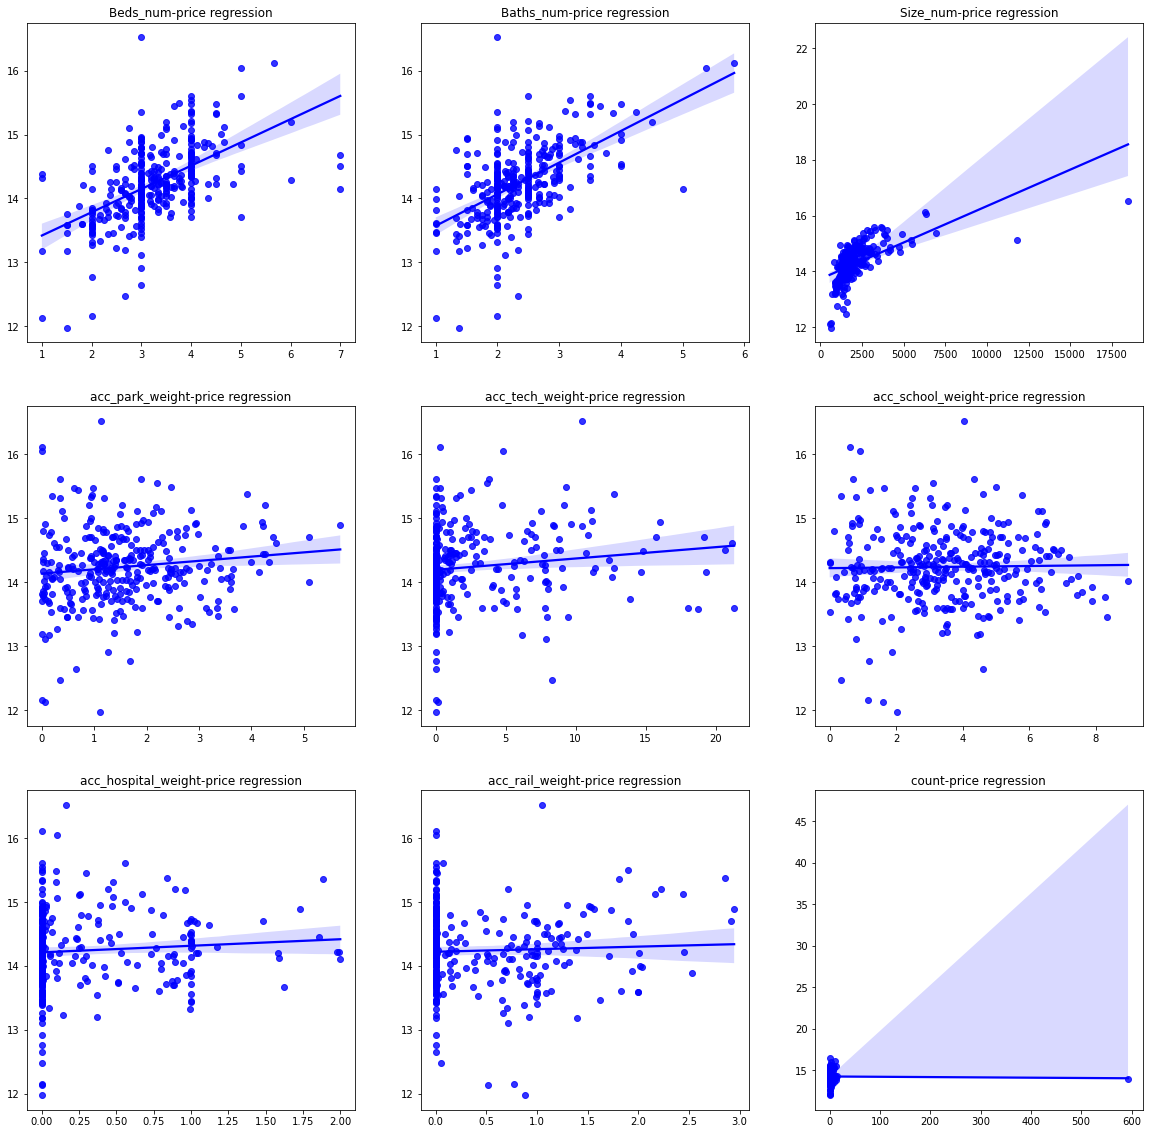

In [239]:
#Visualize Regression
fig, ax = plt.subplots(3,3, figsize=(20,20))
a=0
for i in np.arange(3):
    for j in np.arange(3):
        a=a+1
        sns.regplot(x=m1.x[:,a], y=m1.y,ax=ax[i,j], color='blue')
        ax[i,j].set_title(x1[a-1] +'-price'+ ' regression')

In [255]:
p_value=pd.DataFrame(m1.t_stat)

In [254]:
coeff=pd.DataFrame(m1.betas)

In [259]:
p_value['coeff']=coeff

Text(0, 0.5, 'coefficient')

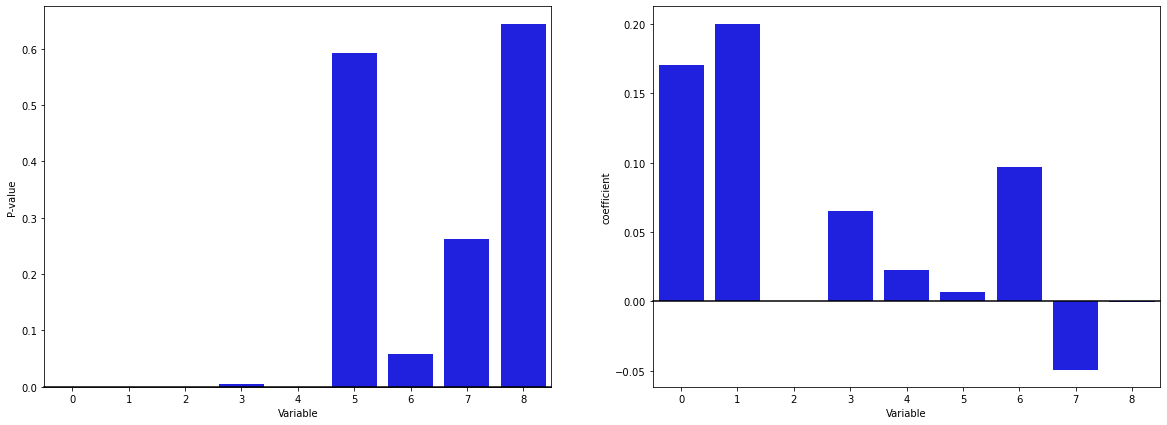

In [290]:
#Visualize P-values & Coefficients
fig, ax = plt.subplots(1,2,figsize=(20,7))

sns.barplot(x=np.arange(9), y=p_value[1][1:10], color="blue",ax=ax[0])
sns.barplot(x=np.arange(9), y=p_value['coeff'][1:10], color="blue",ax=ax[1])

ax[0].axhline(0, color="k", clip_on=False)
ax[1].axhline(0, color="k", clip_on=False)

ax[0].set_xlabel("Variable")
ax[0].set_ylabel("P-value")

ax[1].set_xlabel("Variable")
ax[1].set_ylabel("coefficient")

#### 2.Geographically Weighted Regression Model (GWR)

In [275]:
#Data Preparation
yxs2 =final.loc[:, x1+['price_num','INTPTLAT10','INTPTLON10','geometry','GEOID10','ALAND10']].dropna()
yxs2

Beds_num  Baths_num     Size_num  acc_park_weight  acc_tech_weight  \
0    2.800000   2.100000  1469.400000         1.994966         4.074664   
1    4.250000   3.375000  4738.500000         5.694102         8.413580   
2    3.000000   1.000000  1371.000000         3.616373         7.789624   
3    3.000000   1.500000  4067.000000         2.586630         2.502046   
4    3.000000   2.000000  6920.000000         0.958403         1.727121   
..        ...        ...          ...              ...              ...   
366  4.083333   2.916667  2581.083333         0.331357         0.000000   
367  2.000000   1.000000  1040.000000         0.136817         0.000000   
368  2.000000   2.000000  1116.000000         1.422750         0.000000   
369  2.666667   2.333333  1319.666667         1.367397         0.000000   
371  1.000000   2.000000  1930.000000         0.016503         0.000952   

     acc_school_weight  acc_hospital_weight  acc_rail_weight  count  \
0             3.230705             0.000000         0.294463      0   
1             2.698903             0.000000         1.563100      6   
2             2.886245             0.009043         2.018087      2   
3             4.016371             1.016371         2.916780      2   
4             5.782862             1.886023         1.805324      2   
..                 ...                  ...              ...    ...   
366           0.821349             0.000000         0.146775      0   
367           0.436378             0.222577         0.513363      7   
368           2.842105             0.000000         0.993209      1   
369           3.381995             0.369830         0.917275      1   
371           0.019359             0.000000         0.000000     10   

        price_num  INTPTLAT10  INTPTLON10  \
0    1.158600e+06   37.358556 -121.892742   
1    2.921972e+06   37.349879 -121.902193   
2    1.198000e+06   37.339586 -121.907971   
3    2.424000e+06   37.340173 -121.922053   
4    4.680000e+06   37.329965 -121.927938   
..            ...         ...         ...   
366  1.572830e+06   36.977546 -121.586350   
367  1.399000e+06   37.018124 -121.524428   
368  7.399000e+05   37.001726 -121.562670   
369  5.396333e+05   37.019822 -121.570580   
371  1.650000e+06   37.248099 -121.527966   

                                              geometry     GEOID10     ALAND10  
0    POLYGON ((597935.5034962505 4135743.433330479,...  6085500100     1954341  
1    POLYGON ((597846.7724980968 4133448.3956936793...  6085500200     1700003  
2    POLYGON ((597060.7221766073 4131620.7175230933...  6085500300     2933489  
3    POLYGON ((595241.4011558085 4132537.0905402214...  6085500400     1013101  
4    POLYGON ((594867.6755625462 4131678.1290151365...  6085500500     2142489  
..                                                 ...         ...         ...  
366  POLYGON ((626830.2657793275 4093892.093295438,...  6085512510    23149914  
367  POLYGON ((633385.0078896736 4092803.7826566137...  6085512602    97139581  
368  POLYGON ((628020.9424493454 4094765.670918972,...  6085512603     2088097  
369  POLYGON ((626944.0179765515 4096833.4408045243...  6085512604     2218017  
371  POLYGON ((640526.3067406232 4139257.366575673,...  6085513500  1527469647  

[323 rows x 15 columns]

In [276]:
#GWR Model
final_geo=gpd.GeoDataFrame(yxs2,crs={'init': 'epsg:26910'})
y2=final_geo[['price_num']].values
x2=final_geo[['Beds_num','Baths_num','Size_num','acc_park_weight','acc_tech_weight', 'acc_school_weight','acc_hospital_weight', 'acc_rail_weight','count']].values
u=final_geo['INTPTLON10']
v=final_geo['INTPTLAT10']
coords = list(zip(u,v))
gwr_selector = Sel_BW(coords, y2, x2)
gwr_bw = gwr_selector.search()
print('GWR bandwidth =', gwr_bw)

GWR bandwidth = 75.0


In [277]:
gwr_results = GWR(coords, y2, x2, gwr_bw).fit()
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 323
Number of covariates:                                                    10

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       186536961914452.156
Log-likelihood:                                                   -4832.060
AIC:                                                               9684.120
AICc:                                                              9686.969
BIC:                                                           186536961912643.750
R2:                                                                   0.706
Adj. R2:                                                              0.697

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---

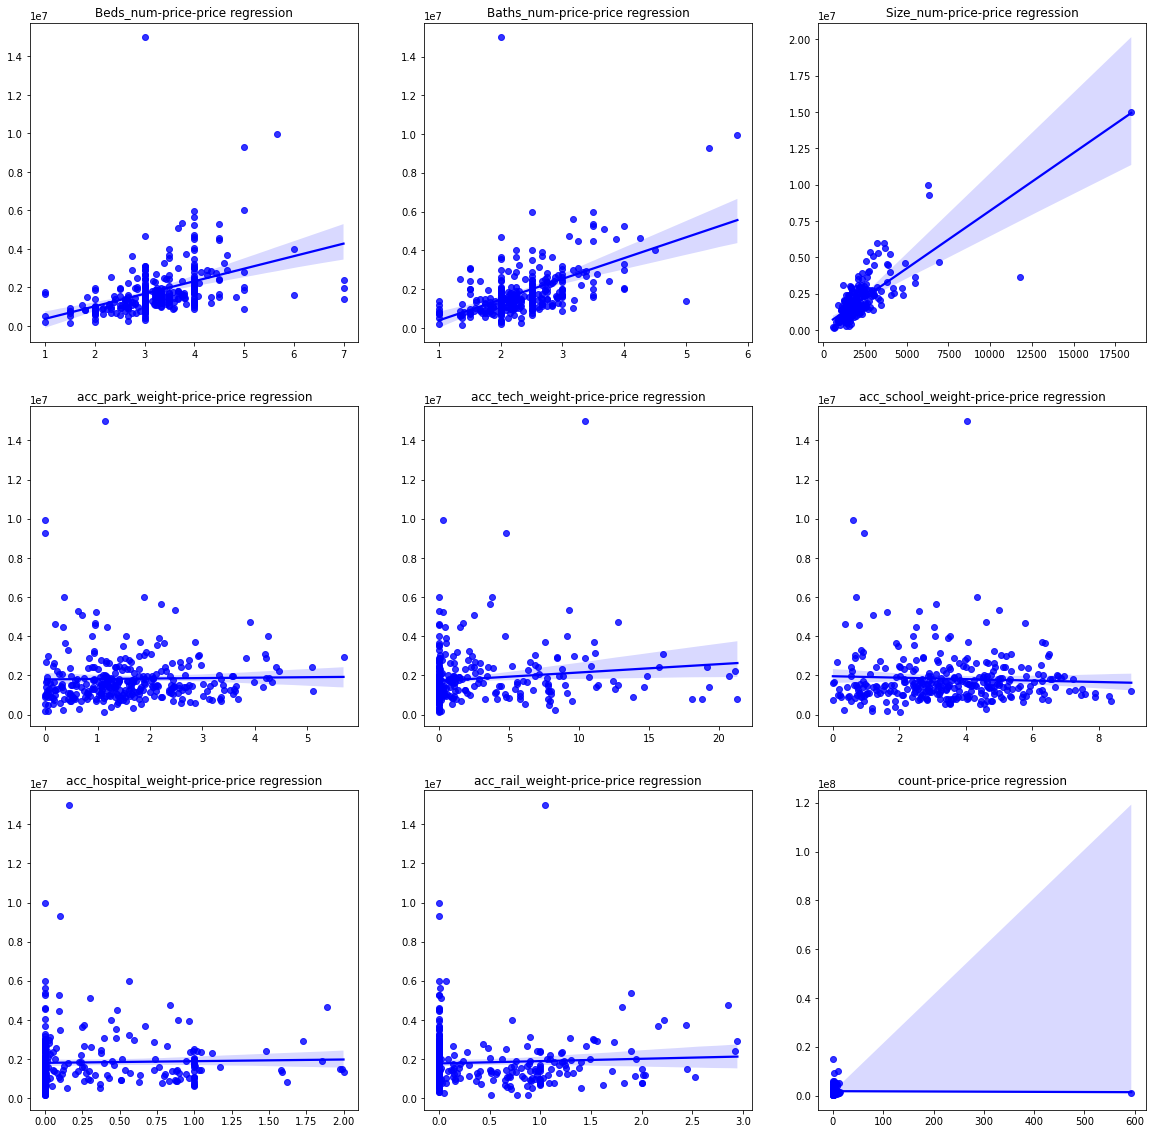

In [284]:
#Visualize Regression II
fig, ax = plt.subplots(3,3, figsize=(20,20))
a=0
for i in np.arange(3):
    for j in np.arange(3):
        a=a+1
        sns.regplot(x=gwr_results.X[:,a], y=gwr_results.y,ax=ax[i,j], color='blue')
        ax[i,j].set_title(x1[a-1] +'-price'+'-price'+ ' regression')

In [316]:
coefficients=pd.DataFrame(gwr_results.params)
mean_coeff=coefficients.mean()

1    169105.871751
2    132696.219426
3       615.357686
4     60362.336471
5    -37893.156322
6     38507.933756
7    -79786.396755
8    -34017.326252
9     22173.200620
dtype: float64

In [314]:
P_values=pd.DataFrame([0.2,0.0,0.0,0.098,0.0,0.866,0.571,0.272,0.814])

Text(0, 0.5, 'Mean_coefficient')

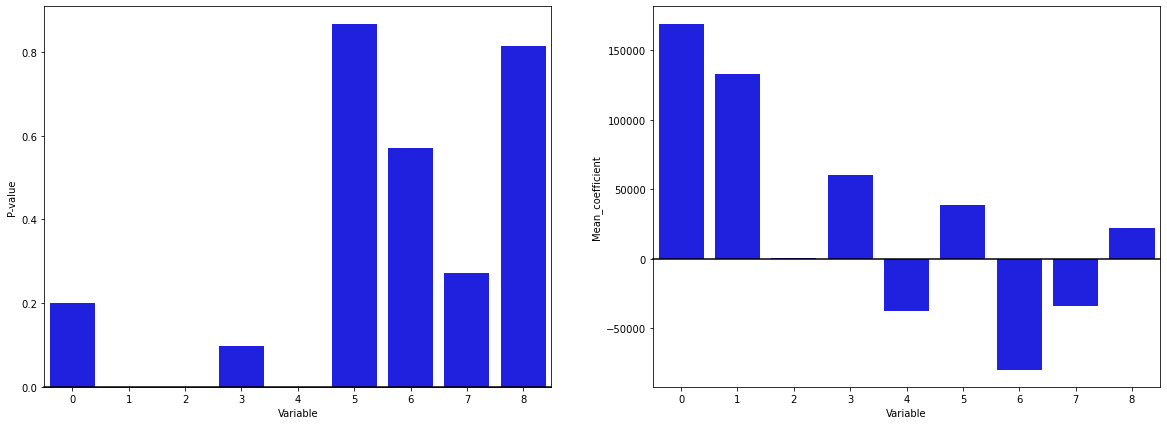

In [325]:
#Visualize P-values & Coefficients
fig, ax = plt.subplots(1,2,figsize=(20,7))

sns.barplot(x=np.arange(9), y=P_values[0], color="blue",ax=ax[0])
sns.barplot(x=np.arange(9), y=mean_coeff[1:10], color="blue",ax=ax[1])

ax[0].axhline(0, color="k", clip_on=False)
ax[1].axhline(0, color="k", clip_on=False)

ax[0].set_xlabel("Variable")
ax[0].set_ylabel("P-value")

ax[1].set_xlabel("Variable")
ax[1].set_ylabel("Mean_coefficient")

In [326]:
final_geo['R2']=gwr_results.localR2
final_geo['R2_str']=1e8*final_geo['R2']/final_geo['ALAND10']
final_geo['geometry'] = gpd.GeoSeries.from_wkt(final_geo['geometry'])

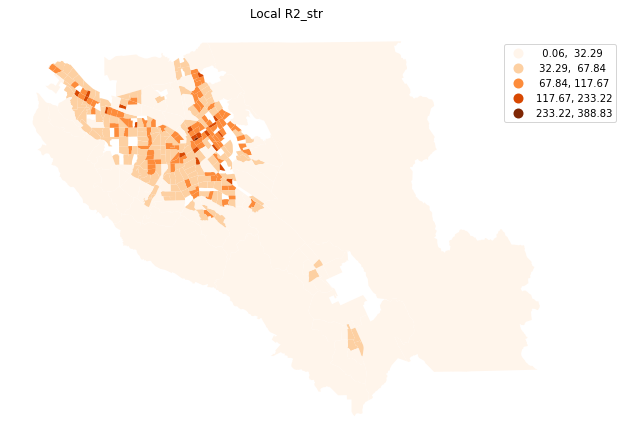

In [327]:
#Visualize Results-Local R2
fig, ax = plt.subplots(figsize=(10, 10))
final_geo.plot(column='R2_str', cmap = 'Oranges', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax)
ax.set_title('Local R2_str', fontsize=12)
ax.axis("off")
plt.show()

In [328]:
# Normalize Coefficients
final_geo['gwr_intercept_str']=gwr_results.params[:,0]/final_geo['ALAND10']
final_geo['gwr_beds_str']=gwr_results.params[:,1]/final_geo['ALAND10']
final_geo['gwr_baths_str']=gwr_results.params[:,2]/final_geo['ALAND10']
final_geo['gwr_size_str']=gwr_results.params[:,3]/final_geo['ALAND10']
final_geo['gwr_park_str']=gwr_results.params[:,4]/final_geo['ALAND10']
final_geo['gwr_tech_str']=gwr_results.params[:,5]/final_geo['ALAND10']
final_geo['gwr_school_str']=gwr_results.params[:,6]/final_geo['ALAND10']
final_geo['gwr_hospital_str']=gwr_results.params[:,7]/final_geo['ALAND10']
final_geo['gwr_rail_str']=gwr_results.params[:,8]/final_geo['ALAND10']
final_geo['gwr_crime_str']=gwr_results.params[:,9]/final_geo['ALAND10']

In [329]:
gwr_filtered_t = gwr_results.filter_tvals(alpha = 0.05)
pd.DataFrame(gwr_filtered_t)

0         1    2          3    4    5    6    7    8    9
0    0.0  0.000000  0.0   9.207057  0.0  0.0  0.0  0.0  0.0  0.0
1    0.0  0.000000  0.0   9.651859  0.0  0.0  0.0  0.0  0.0  0.0
2    0.0  0.000000  0.0   9.771978  0.0  0.0  0.0  0.0  0.0  0.0
3    0.0  0.000000  0.0   9.915856  0.0  0.0  0.0  0.0  0.0  0.0
4    0.0  2.854166  0.0  10.422471  0.0  0.0  0.0  0.0  0.0  0.0
..   ...       ...  ...        ...  ...  ...  ...  ...  ...  ...
318  0.0  0.000000  0.0   2.781975  0.0  0.0  0.0  0.0  0.0  0.0
319  0.0  0.000000  0.0   2.759981  0.0  0.0  0.0  0.0  0.0  0.0
320  0.0  0.000000  0.0   2.760156  0.0  0.0  0.0  0.0  0.0  0.0
321  0.0  0.000000  0.0   2.804579  0.0  0.0  0.0  0.0  0.0  0.0
322  0.0  0.000000  0.0   3.569390  0.0  0.0  0.0  0.0  0.0  0.0

[323 rows x 10 columns]

In [330]:
gwr_filtered_tc = gwr_results.filter_tvals()
pd.DataFrame(gwr_filtered_tc)

0         1    2          3    4    5    6    7    8    9
0    0.0  0.000000  0.0   9.207057  0.0  0.0  0.0  0.0  0.0  0.0
1    0.0  0.000000  0.0   9.651859  0.0  0.0  0.0  0.0  0.0  0.0
2    0.0  0.000000  0.0   9.771978  0.0  0.0  0.0  0.0  0.0  0.0
3    0.0  0.000000  0.0   9.915856  0.0  0.0  0.0  0.0  0.0  0.0
4    0.0  2.854166  0.0  10.422471  0.0  0.0  0.0  0.0  0.0  0.0
..   ...       ...  ...        ...  ...  ...  ...  ...  ...  ...
318  0.0  0.000000  0.0   2.781975  0.0  0.0  0.0  0.0  0.0  0.0
319  0.0  0.000000  0.0   0.000000  0.0  0.0  0.0  0.0  0.0  0.0
320  0.0  0.000000  0.0   0.000000  0.0  0.0  0.0  0.0  0.0  0.0
321  0.0  0.000000  0.0   2.804579  0.0  0.0  0.0  0.0  0.0  0.0
322  0.0  0.000000  0.0   3.569390  0.0  0.0  0.0  0.0  0.0  0.0

[323 rows x 10 columns]

In [331]:
gwr_var=['gwr_intercept_str','gwr_beds_str','gwr_baths_str','gwr_size_str','gwr_park_str','gwr_tech_str','gwr_school_str','gwr_hospital_str','gwr_rail_str','gwr_crime_str']

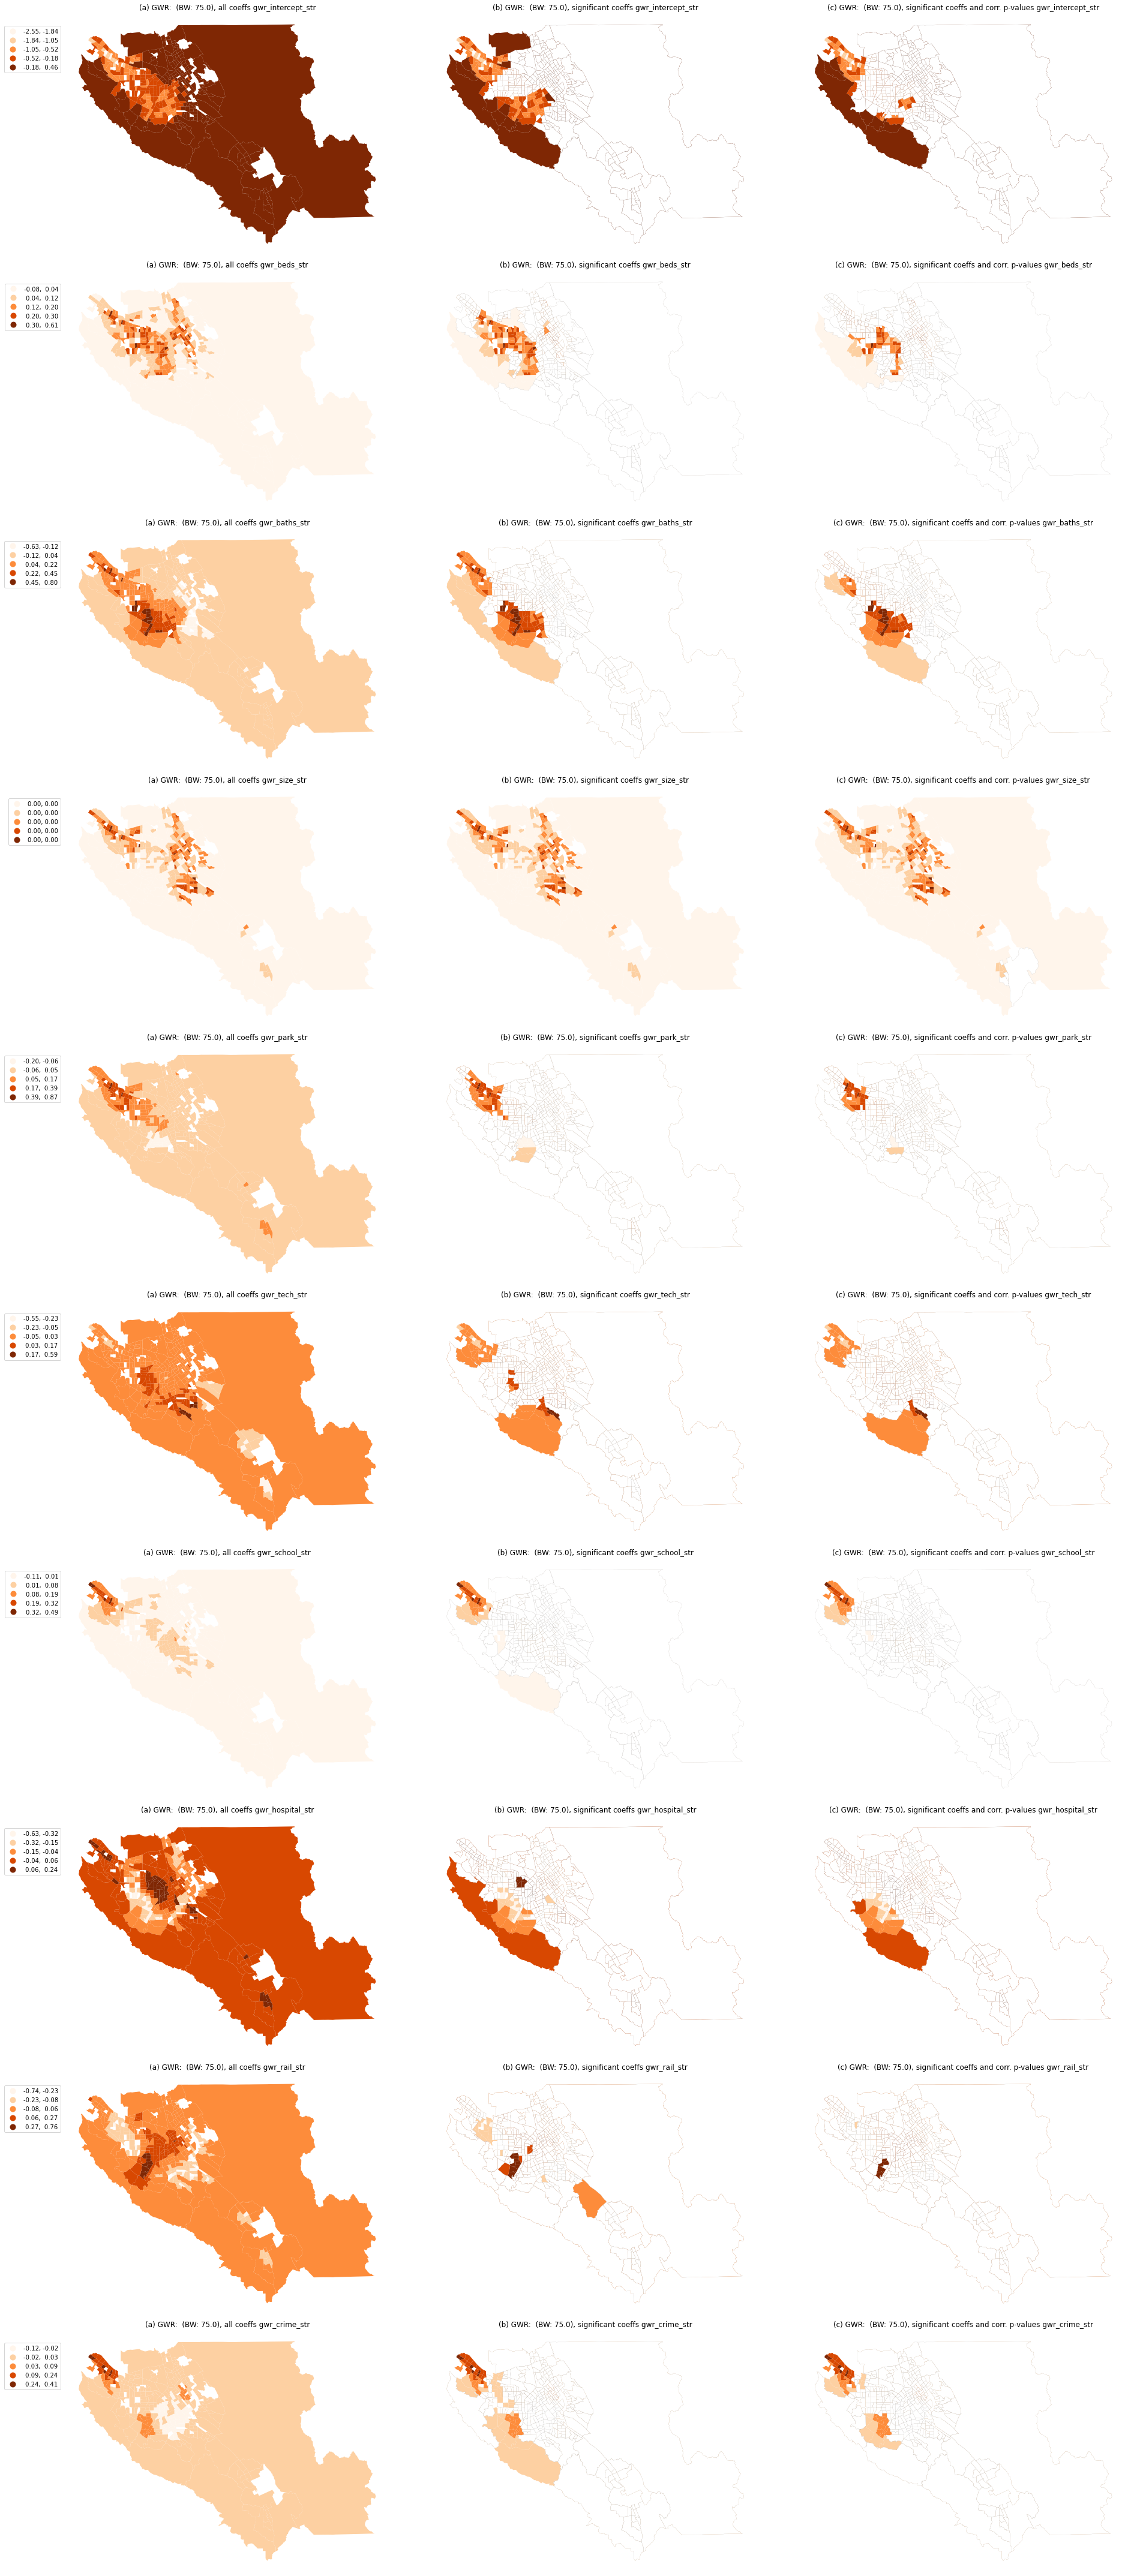

In [344]:
#Visualize Results-coefficients
fig, ax = plt.subplots(10,3, figsize=(27,60))
x=0
for i in np.arange(10):
        final_geo.plot(column=gwr_var[i], cmap = 'Oranges', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(0, 0.96)},  ax=ax[i,0])
        
        final_geo.plot(column=gwr_var[i], cmap = 'Oranges', linewidth=0.05, scheme = 'FisherJenks', k=5, legend=False, legend_kwds={'bbox_to_anchor':(1.5, 0.96)},  ax=ax[i,1])
        final_geo[gwr_filtered_t[:,i] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=ax[i,1])
        
        final_geo.plot(column=gwr_var[i], cmap = 'Oranges', linewidth=0.05, scheme = 'FisherJenks', k=5, legend=False, legend_kwds={'bbox_to_anchor':(1.5, 0.96)},  ax=ax[i,2])
        final_geo[gwr_filtered_tc[:,i] == 0].plot(color='white', linewidth=0.05, edgecolor='black', ax=ax[i,2])
        
        plt.tight_layout()
        ax[i,0].axis("off")
        ax[i,1].axis("off")
        ax[i,2].axis("off")
        ax[i,0].set_title('(a) GWR:  (BW: ' + str(gwr_bw) +'), all coeffs '+ gwr_var[i], fontsize=12)
        ax[i,1].set_title('(b) GWR:  (BW: ' + str(gwr_bw) +'), significant coeffs '+ gwr_var[i], fontsize=12)
        ax[i,2].set_title('(c) GWR:  (BW: ' + str(gwr_bw) +'), significant coeffs and corr. p-values '+ gwr_var[i], fontsize=12)


plt.show()

In [351]:
#Visualize Results-multicollinearity
LCC, VIF, CN, VDP = gwr_results.local_collinearity()
pd.DataFrame(VIF)
pd.DataFrame(VIF).describe().round(2)
pd.DataFrame(CN)
final_geo['gwr_CN'] = CN
final_geo['CN_str']=1e8*final_geo['gwr_CN']/final_geo['ALAND10']

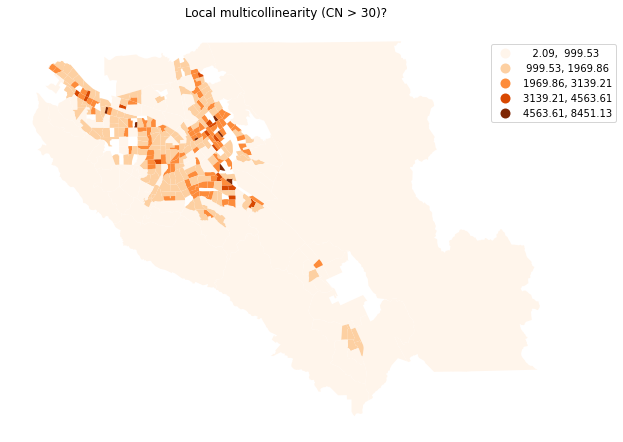

In [352]:
fig, ax = plt.subplots(figsize=(10, 10))
final_geo.plot(column='CN_str', cmap = 'Oranges', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax)
ax.set_title('Local multicollinearity (CN > 30)?', fontsize=12)
ax.axis("off")
#plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()

## III-Conclusions + Contributions + Limitations

#### 1.Conclusions

From the analysis above, several key findings can be concluded:
*  In both the GWR model and basic regression model, compared with environmental & locational factors, **structural factors including beds/baths/sizes have more significant influences on housing prices**. These factors tend to have larger coefficients and less P-value (1%-10%).



*  In both models, two of the environmental factors are statistically significant: **Park Accessibility** and **Tech Company Accessibility**. While these two factors have a generally positive influence on housing prices in the first model, results in the second model show diversified influences of factors due to potential geographical differences.


*  In the second model, we can see housing prices in areas such as **West Santa Clara (Palo Alto, etc.)** are influenced by comprehensive factors (structural+environmental+locational), while areas like **East Santa Clara (Downtown San Jose)** are less influenced by environmental and locational factors (Park/Tech/School Accessibility). The demograhical analysis also shows that East Santa Clara has **a lager population density**, especially **hispanic population.**


*  Compared with the basic regression model **(R2=0.586)**, the GWR model has a larger **R2=0.706**, which indicates the GWR model can provide a more suitable fit to the data collected by considering geographical weights.


#### 2.Contributions

The study can be used by future **home buyers/city planners/urban designers** as a reference to **make purchase decisions/develop affordable housing projects+service facilities** in different areas of Santa Clara County. For example, more mix-used affordable housing+public space projects in Downtown San Jose to increase both affordability and park accessibility for vulnerable groups.

#### 3.Limitations

Due to time limits, data collection is not perfect. Threre are many other possible factors that have not been taken into consideration. Also some databases are not large enough to be used to do analysis (e.g., there are only around 1000 records in the real estate dataset).

## IV-References

[1]Piotr Czembrowski, Jakub Kronenberg, Hedonic pricing and different urban green space types and sizes: Insights into the discussion on valuing ecosystem services, Landscape and Urban Planning, Volume 146, 2016, Pages 11-19, ISSN 0169-2046, https://doi.org/10.1016/j.landurbplan.2015.10.005.


[2]AM-34 - The Geographically Weighted Regression Framework,UCGIS, https://gistbok.ucgis.org/bok-topics/geographically-weighted-regression-framework

[3]Spatial Regression, Geographic Data Science with PySAL and the pydata stack, http://darribas.org/gds_scipy16/ipynb_md/08_spatial_regression.html

[4]Introduction to GWR and MGWR,Carlos Mendez [PYTHON] GWR and MGWR, deepnote.com, https://deepnote.com/@carlos-mendez/PYTHON-GWR-and-MGWR-71dd8ba9-a3ea-4d28-9b20-41cc8a282b7a